# Forecasting weekly wind energy generation in New Zealand
Model - SARIMA

This notebook addresses:
* RQ1: How well does a SARIMA model forecast weekly wind energy generation?
* RQ2: Does incorporating weekly-aggregated climate variables into SARIMAX improve forecasting accuracy?

The analysis uses weekly sumed and weekly averaged NASA climate data, aligned with operational wind generation data.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import tensorflow as tf
import seaborn as sns
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Dropout, BatchNormalization, LeakyReLU
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error , root_mean_squared_error , mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau



## EDA - Wind

In [4]:
# # 1: Load all datasets 
wind_energy = pd.read_csv('Wind_data.csv')
daily_all_nsp_ps = pd.read_csv('Wind_Factor_ALL_NSP_Daily_PS.csv')
daily_all_nsp_t2m = pd.read_csv('Wind_Factor_ALL_NSP_Daily_T2M.csv')
daily_all_nsp_wd50m = pd.read_csv('Wind_Factor_ALL_NSP_Daily_WD50M.csv')
daily_all_nsp_ws50m = pd.read_csv('Wind_Factor_ALL_NSP_Daily_WS50M.csv')

In [5]:
print(wind_energy.dtypes)

Fuel_Code     object
POC_Code      object
DATE          object
Total_TP     float64
Island        object
Latitude     float64
Longitude    float64
dtype: object


In [6]:
wind_energy.head(5)

,Fuel_Code,POC_Code,DATE,Total_TP,Island,Latitude,Longitude
0,Wind,BPE0331,2015-03-01,472971.4800,NI,-40.280614,175.64051
1,Wind,BPE0331,2015-03-02,119485.1800,NI,-40.280614,175.64051
2,Wind,BPE0331,2015-03-03,173416.5861,NI,-40.280614,175.64051
3,Wind,BPE0331,2015-03-04,127370.3811,NI,-40.280614,175.64051
4,Wind,BPE0331,2015-03-05,59379.3772,NI,-40.280614,175.64051


In [7]:
# format date column
wind_energy['DATE'] = pd.to_datetime(wind_energy['DATE'], format='%Y-%m-%d')
daily_all_nsp_ps['DATE'] = pd.to_datetime(daily_all_nsp_ps['DATE'], format='%Y-%m-%d')
daily_all_nsp_wd50m['DATE'] = pd.to_datetime(daily_all_nsp_wd50m['DATE'], format='%Y-%m-%d')
daily_all_nsp_t2m['DATE'] = pd.to_datetime(daily_all_nsp_t2m['DATE'], format='%Y-%m-%d')
daily_all_nsp_ws50m['DATE'] = pd.to_datetime(daily_all_nsp_ws50m['DATE'], format='%Y-%m-%d')

In [8]:
print(wind_energy.dtypes)
print("-------------------------")
print(daily_all_nsp_ps.dtypes)
print("-------------------------")
print(daily_all_nsp_wd50m.dtypes)
print("-------------------------")
print(daily_all_nsp_t2m.dtypes)
print("-------------------------")
print(daily_all_nsp_ws50m.dtypes)
print("-------------------------")

Fuel_Code            object
POC_Code             object
DATE         datetime64[ns]
Total_TP            float64
Island               object
Latitude            float64
Longitude           float64
dtype: object
-------------------------
DATE         datetime64[ns]
POC_Code             object
PS                  float64
Island               object
Fuel_Code            object
Latitude            float64
Longitude           float64
dtype: object
-------------------------
DATE         datetime64[ns]
POC_Code             object
WD50M               float64
WD50M_rad           float64
u                   float64
v                   float64
Island               object
Fuel_Code            object
Latitude            float64
Longitude           float64
dtype: object
-------------------------
DATE         datetime64[ns]
POC_Code             object
T2M                 float64
Island               object
Fuel_Code            object
Latitude            float64
Longitude           float64
dtype: objec

In [9]:
print(wind_energy.head(5))
print("-------------------------")
print(daily_all_nsp_ps.head(5))
print("-------------------------")
print(daily_all_nsp_wd50m.head(5))
print("-------------------------")
print(daily_all_nsp_t2m.head(5))
print("-------------------------")
print(daily_all_nsp_ws50m.head(5))
print("-------------------------")

  Fuel_Code POC_Code       DATE     Total_TP Island   Latitude  Longitude
0      Wind  BPE0331 2015-03-01  472971.4800     NI -40.280614  175.64051
1      Wind  BPE0331 2015-03-02  119485.1800     NI -40.280614  175.64051
2      Wind  BPE0331 2015-03-03  173416.5861     NI -40.280614  175.64051
3      Wind  BPE0331 2015-03-04  127370.3811     NI -40.280614  175.64051
4      Wind  BPE0331 2015-03-05   59379.3772     NI -40.280614  175.64051
-------------------------
        DATE POC_Code     PS Island Fuel_Code   Latitude  Longitude
0 2015-01-01  BPE0331  99.16     NI      Wind -40.280614  175.64051
1 2015-01-02  BPE0331  99.64     NI      Wind -40.280614  175.64051
2 2015-01-03  BPE0331  99.90     NI      Wind -40.280614  175.64051
3 2015-01-04  BPE0331  99.88     NI      Wind -40.280614  175.64051
4 2015-01-05  BPE0331  99.59     NI      Wind -40.280614  175.64051
-------------------------
        DATE POC_Code  WD50M  WD50M_rad         u         v Island Fuel_Code  \
0 2015-01-01  BP

In [10]:
# # 3. Function to extract unique (POC_Code, YearMonth) combinations as a set of tuples
# def get_poc_yearmonth(df):
#     return set(df[['POC_Code', 'YearMonth']].apply(lambda row: (row['POC_Code'], row['YearMonth']), axis=1))

# # Extract unique combinations from each DataFrame
# wind_energy_combos = get_poc_yearmonth(wind_energy)
# ps_combos = get_poc_yearmonth(daily_all_nsp_ps)
# t2m_combos = get_poc_yearmonth(daily_all_nsp_t2m)
# wd50m_combos = get_poc_yearmonth(daily_all_nsp_wd50m)
# ws50m_combos = get_poc_yearmonth(daily_all_nsp_ws50m)

# # 4. Find the common combinations across all five DataFrames
# common_combos = wind_energy_combos & ps_combos & t2m_combos & wd50m_combos & ws50m_combos

# print("Number of common (POC_Code, YearMonth) combinations:", len(common_combos))
# print("Sample common combinations:", list(common_combos)[:10])  # print a sample

# # 5. Check for extra combinations in each DataFrame that are not in the common set
# print("Extra in wind_energy:", wind_energy_combos - common_combos)
# print("Extra in Daily NSP PS:", ps_combos - common_combos)
# print("Extra in Daily NSP T2M:", t2m_combos - common_combos)
# print("Extra in Daily NSP WD50M:", wd50m_combos - common_combos)
# print("Extra in Daily NSP WS50M:", ws50m_combos - common_combos)

In [11]:
# merge1.head()

In [12]:
# # Merge merge1 with daily_all_nsp_t2m
merge1 = pd.merge(daily_all_nsp_ps[['DATE', 'POC_Code','PS']], daily_all_nsp_t2m[['DATE','POC_Code','T2M']], on=['POC_Code', 'DATE'], how='inner')
print("Merge 1 PS & T2M : ", merge1.shape)

Merge 1 PS & T2M :  (48256, 4)


In [13]:
# merge2.head()

In [14]:
# # Merge merge2 with daily_all_nsp_wd50m
merge2 = pd.merge(merge1, daily_all_nsp_wd50m[['DATE','POC_Code','WD50M','WD50M_rad','u','v']], on=['POC_Code', 'DATE'], how='inner')
print("Merge 2 : Merge 1 & WD50M : ", merge2.shape)

Merge 2 : Merge 1 & WD50M :  (48256, 8)


In [15]:
# merge3.head()

In [16]:
# # Merge merge3 with daily_all_nsp_ws50m
merge3 = pd.merge(merge2, daily_all_nsp_ws50m[['DATE','POC_Code','WS50M']], on=['POC_Code', 'DATE'], how='inner',)
print("Merge 3 : Merge 2 & WD50M :", merge3.shape)

Merge 3 : Merge 2 & WD50M : (48256, 9)


In [17]:
# # Merge wind_energy and daily_all_nsp_ps
final_merge = pd.merge(wind_energy, merge3, on=['POC_Code', 'DATE'], how='left')
print("Final Merge Wind & Merge 3", final_merge.shape)

Final Merge Wind & Merge 3 (35020, 14)


In [18]:
final_merge.head()

,Fuel_Code,POC_Code,DATE,Total_TP,Island,Latitude,Longitude,PS,T2M,WD50M,WD50M_rad,u,v,WS50M
0,Wind,BPE0331,2015-03-01,472971.4800,NI,-40.280614,175.64051,99.50,18.88,302.2,5.274385,0.532876,-0.846193,5.89
1,Wind,BPE0331,2015-03-02,119485.1800,NI,-40.280614,175.64051,99.39,18.43,304.9,5.321509,0.572146,-0.820152,6.52
2,Wind,BPE0331,2015-03-03,173416.5861,NI,-40.280614,175.64051,99.24,18.92,302.8,5.284857,0.541708,-0.840567,5.08
3,Wind,BPE0331,2015-03-04,127370.3811,NI,-40.280614,175.64051,98.90,18.34,315.5,5.506514,0.713250,-0.700909,4.19
4,Wind,BPE0331,2015-03-05,59379.3772,NI,-40.280614,175.64051,98.46,19.62,328.2,5.728171,0.849893,-0.526956,3.64


In [19]:
# Write the final merged DataFrame to a CSV file
final_merge.to_csv('EDA_Wind_all_nsp.csv', index=False)

print("Final merge saved to final_merged.csv")

Final merge saved to final_merged.csv


In [20]:
# all_poc_data = pd.read_csv('final_merged_v5_combined_all_V1.csv')

In [21]:
all_poc_data = final_merge.copy()

In [22]:
all_poc_data.head()

,Fuel_Code,POC_Code,DATE,Total_TP,Island,Latitude,Longitude,PS,T2M,WD50M,WD50M_rad,u,v,WS50M
0,Wind,BPE0331,2015-03-01,472971.4800,NI,-40.280614,175.64051,99.50,18.88,302.2,5.274385,0.532876,-0.846193,5.89
1,Wind,BPE0331,2015-03-02,119485.1800,NI,-40.280614,175.64051,99.39,18.43,304.9,5.321509,0.572146,-0.820152,6.52
2,Wind,BPE0331,2015-03-03,173416.5861,NI,-40.280614,175.64051,99.24,18.92,302.8,5.284857,0.541708,-0.840567,5.08
3,Wind,BPE0331,2015-03-04,127370.3811,NI,-40.280614,175.64051,98.90,18.34,315.5,5.506514,0.713250,-0.700909,4.19
4,Wind,BPE0331,2015-03-05,59379.3772,NI,-40.280614,175.64051,98.46,19.62,328.2,5.728171,0.849893,-0.526956,3.64


In [23]:
# Check for missing values in each column
missing_values = all_poc_data.isnull().sum()
print(missing_values)

# Optionally, check if there are any missing values at all
if all_poc_data.isnull().values.any():
    print("There are missing values in the DataFrame.")
else:
    print("No missing values found in the DataFrame.")

Fuel_Code    0
POC_Code     0
DATE         0
Total_TP     0
Island       0
Latitude     0
Longitude    0
PS           0
T2M          0
WD50M        0
WD50M_rad    0
u            0
v            0
WS50M        0
dtype: int64
No missing values found in the DataFrame.


In [24]:
# List all column names as an Index object
print(all_poc_data.columns)

# list the column names
print(all_poc_data.columns.tolist())

Index(['Fuel_Code', 'POC_Code', 'DATE', 'Total_TP', 'Island', 'Latitude',
       'Longitude', 'PS', 'T2M', 'WD50M', 'WD50M_rad', 'u', 'v', 'WS50M'],
      dtype='object')
['Fuel_Code', 'POC_Code', 'DATE', 'Total_TP', 'Island', 'Latitude', 'Longitude', 'PS', 'T2M', 'WD50M', 'WD50M_rad', 'u', 'v', 'WS50M']


In [25]:
print(all_poc_data.dtypes)

Fuel_Code            object
POC_Code             object
DATE         datetime64[ns]
Total_TP            float64
Island               object
Latitude            float64
Longitude           float64
PS                  float64
T2M                 float64
WD50M               float64
WD50M_rad           float64
u                   float64
v                   float64
WS50M               float64
dtype: object


In [26]:
# selected_columns_POC = ['Fuel_Code','POC_Code', 'DATE','Total_TP', 'PS','T2M','WD50M','WD50M_rad','u','v','WS50M']  # Replace with your desired column names


In [27]:
wind_selected_col = ['DATE', 'Total_TP', 'Island', 'PS', 'T2M', 'WD50M', 'WD50M_rad', 'u', 'v', 'WS50M']  
# replce for desired column names


In [28]:
df_wind_daily_all_nsp = all_poc_data[wind_selected_col].copy()

In [29]:
df_wind_daily_all_nsp.head()

,DATE,Total_TP,Island,PS,T2M,WD50M,WD50M_rad,u,v,WS50M
0,2015-03-01,472971.4800,NI,99.50,18.88,302.2,5.274385,0.532876,-0.846193,5.89
1,2015-03-02,119485.1800,NI,99.39,18.43,304.9,5.321509,0.572146,-0.820152,6.52
2,2015-03-03,173416.5861,NI,99.24,18.92,302.8,5.284857,0.541708,-0.840567,5.08
3,2015-03-04,127370.3811,NI,98.90,18.34,315.5,5.506514,0.713250,-0.700909,4.19
4,2015-03-05,59379.3772,NI,98.46,19.62,328.2,5.728171,0.849893,-0.526956,3.64


In [30]:
df_wind_daily_all_nsp.set_index('DATE', inplace=True)

In [31]:
record_counts = df_wind_daily_all_nsp.groupby('Island').size()
print(record_counts)

Island
NI    30876
SI     4144
dtype: int64


In [32]:
# 1. Define your custom agg: sum for some columns, mean for the rest
agg_dict = {
    'Total_TP':    'sum',
    'PS':          'mean',
    'T2M':         'mean',
    'WS50M':       'mean',
   }

In [33]:
# Perform weekly aggregation grouped by Island
df_wind_weekly = df_wind_daily_all_nsp.groupby([pd.Grouper(freq='W'), 'Island']).agg(agg_dict)

In [34]:
df_wind_weekly.head()

Total_TP          PS        T2M     WS50M
DATE       Island                                               
2015-03-01 NI      5.260841e+06  100.112857  19.091429  5.437143
           SI      6.983304e+05  100.890000  16.700000  6.830000
2015-03-08 NI      2.970966e+07   99.060204  18.372449  7.480408
           SI      2.978269e+06   99.881429  13.911429  6.545714
2015-03-15 NI      1.724348e+07   99.761224  17.476327  4.644694

In [35]:
#North Island specific data
df_wind_weekly_north = df_wind_weekly.xs('NI', level='Island')

In [36]:
df_wind_weekly_north.head()

,Total_TP,PS,T2M,WS50M
DATE,,,,
2015-03-01,5.260841e+06,100.112857,19.091429,5.437143
2015-03-08,2.970966e+07,99.060204,18.372449,7.480408
2015-03-15,1.724348e+07,99.761224,17.476327,4.644694
2015-03-22,2.317096e+07,99.580612,13.854694,7.118980
2015-03-29,2.053256e+07,99.906531,16.650408,5.629796


In [37]:
#South Island specific data
df_wind_weekly_south = df_wind_weekly.xs('SI', level='Island')

In [38]:
df_wind_weekly_south.head()

,Total_TP,PS,T2M,WS50M
DATE,,,,
2015-03-01,6.983304e+05,100.890000,16.700000,6.830000
2015-03-08,2.978269e+06,99.881429,13.911429,6.545714
2015-03-15,2.755933e+06,101.075714,13.817143,4.945714
2015-03-22,2.169076e+06,101.260000,11.324286,5.302857
2015-03-29,1.893987e+06,100.988571,13.421429,3.867143


In [39]:
# Check for rows where Total_TP equals 0.0
zero_records_south = df_wind_weekly_south[df_wind_weekly_south['Total_TP'] == 0.0]
print("South Island : Number of weekly records with Total_TP equal to 0:", len(zero_records_south))
print(zero_records_south)

South Island : Number of weekly records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, PS, T2M, WS50M]
Index: []


In [40]:
# Check for rows where Total_TP equals 0.0
zero_records_north = df_wind_weekly_north[df_wind_weekly_north['Total_TP'] == 0.0]
print("North Island : Number of weekly records with Total_TP equal to 0:", len(zero_records_north))
print(zero_records_south)

North Island : Number of weekly records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, PS, T2M, WS50M]
Index: []


In [41]:
print(df_wind_weekly_north.shape)

(519, 4)


In [42]:
print(df_wind_weekly_south.shape)

(519, 4)


In [43]:
df_wind_weekly_north_before = df_wind_weekly_north.copy()

In [44]:
print(df_wind_weekly_north_before.shape)

(519, 4)


In [45]:
# Drop the 2015‑03‑01 and 2025-02-02	 rows , looks incomplete
df_wind_weekly_north = df_wind_weekly_north.drop(index=pd.to_datetime('2015-03-01'))

In [46]:
df_wind_weekly_north = df_wind_weekly_north.drop(index=pd.to_datetime('2025-02-02'))

In [47]:
print(df_wind_weekly_north.shape)

(517, 4)


In [48]:
df_wind_weekly_south_before = df_wind_weekly_south.copy()

In [49]:
print(df_wind_weekly_south_before.shape)

(519, 4)


In [50]:
# Drop the 2015‑03‑01 and 2025-02-02	 rows , looks incomplete
df_wind_weekly_south = df_wind_weekly_south.drop(index=pd.to_datetime('2015-03-01'))

In [51]:
df_wind_weekly_south = df_wind_weekly_south.drop(index=pd.to_datetime('2025-02-02'))

In [52]:
print(df_wind_weekly_south.shape)

(517, 4)


In [53]:
df_wind_weekly_south.head()

,Total_TP,PS,T2M,WS50M
DATE,,,,
2015-03-08,2.978269e+06,99.881429,13.911429,6.545714
2015-03-15,2.755933e+06,101.075714,13.817143,4.945714
2015-03-22,2.169076e+06,101.260000,11.324286,5.302857
2015-03-29,1.893987e+06,100.988571,13.421429,3.867143
2015-04-05,4.960861e+06,101.465714,13.738571,7.328571


In [54]:
df_wind_weekly_north.head()

,Total_TP,PS,T2M,WS50M
DATE,,,,
2015-03-08,2.970966e+07,99.060204,18.372449,7.480408
2015-03-15,1.724348e+07,99.761224,17.476327,4.644694
2015-03-22,2.317096e+07,99.580612,13.854694,7.118980
2015-03-29,2.053256e+07,99.906531,16.650408,5.629796
2015-04-05,3.000496e+07,100.376327,16.031224,6.114286


In [55]:
# Check for missing values before handling
nan_count = df_wind_weekly_south['Total_TP'].isna().sum()
print("Number of NaN values before cleaning:", nan_count)

Number of NaN values before cleaning: 0


# Correlation Analysis Between Climate Features and Wind Generation

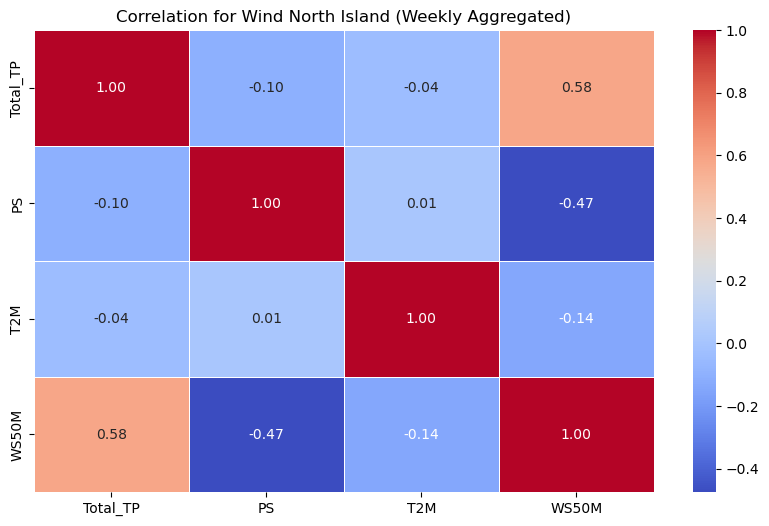

In [57]:
# Compute correlation matrix - North Island
correlation_matrix_wind_north = df_wind_weekly_north.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_wind_north, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation for Wind North Island (Weekly Aggregated)')
plt.show()

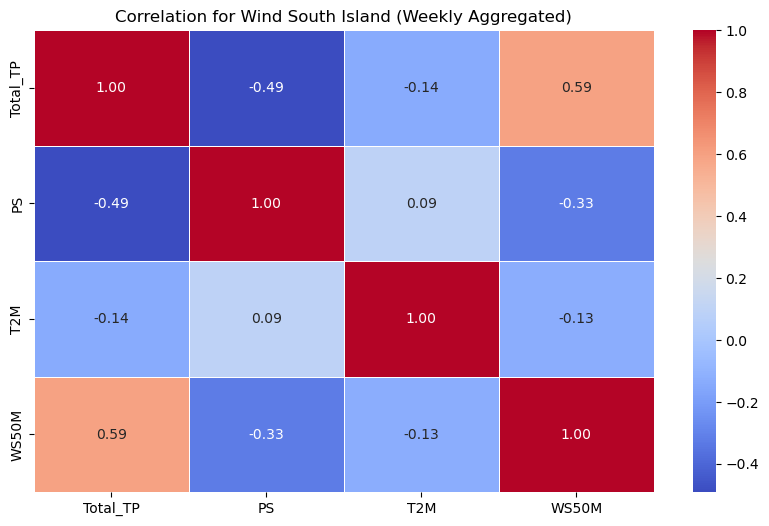

In [58]:
# Compute correlation matrix - North Island
correlation_matrix_wind_south = df_wind_weekly_south.corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix_wind_south, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation for Wind South Island (Weekly Aggregated)')
plt.show()

In [59]:
# Add 1 to 2-week lagged climate features
df_wind_weekly_north['TP_lag1w'] = df_wind_weekly_north['Total_TP'].shift(1)
df_wind_weekly_north['T2M_lag1w'] = df_wind_weekly_north['T2M'].shift(1)
df_wind_weekly_north['PS_lag1w'] = df_wind_weekly_north['PS'].shift(1)
df_wind_weekly_north['WS50M_lag1w'] = df_wind_weekly_north['WS50M'].shift(1)
df_wind_weekly_north['WS50M_lag2w'] = df_wind_weekly_north['WS50M'].shift(2)
df_wind_weekly_north['WS50M_EWMA'] = df_wind_weekly_north['WS50M'].ewm(alpha=0.3, adjust=False).mean()
#df_hydro_weekly_north['APIxGWETPROF'] = df_hydro_weekly_north['PRECIP_EWMA'] * df_hydro_weekly_north['GWETPROF']

In [60]:
print(df_wind_weekly_north.columns.tolist())

['Total_TP', 'PS', 'T2M', 'WS50M', 'TP_lag1w', 'T2M_lag1w', 'PS_lag1w', 'WS50M_lag1w', 'WS50M_lag2w', 'WS50M_EWMA']


In [61]:
df_wind_weekly_north.head()

,Total_TP,PS,T2M,WS50M,TP_lag1w,T2M_lag1w,PS_lag1w,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA
DATE,,,,,,,,,,
2015-03-08,2.970966e+07,99.060204,18.372449,7.480408,NaN,NaN,NaN,NaN,NaN,7.480408
2015-03-15,1.724348e+07,99.761224,17.476327,4.644694,2.970966e+07,18.372449,99.060204,7.480408,NaN,6.629694
2015-03-22,2.317096e+07,99.580612,13.854694,7.118980,1.724348e+07,17.476327,99.761224,4.644694,7.480408,6.776480
2015-03-29,2.053256e+07,99.906531,16.650408,5.629796,2.317096e+07,13.854694,99.580612,7.118980,4.644694,6.432474
2015-04-05,3.000496e+07,100.376327,16.031224,6.114286,2.053256e+07,16.650408,99.906531,5.629796,7.118980,6.337018


In [62]:
# Retain only lagged + target, drop NA
df_wind_weekly_lagged_north = df_wind_weekly_north[['Total_TP', 'PS', 'T2M', 'WS50M', 'TP_lag1w', 'T2M_lag1w', 'PS_lag1w', 'WS50M_lag1w', 'WS50M_lag2w', 'WS50M_EWMA']].dropna()
df_wind_weekly_lagged_north.head()

,Total_TP,PS,T2M,WS50M,TP_lag1w,T2M_lag1w,PS_lag1w,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA
DATE,,,,,,,,,,
2015-03-22,2.317096e+07,99.580612,13.854694,7.118980,1.724348e+07,17.476327,99.761224,4.644694,7.480408,6.776480
2015-03-29,2.053256e+07,99.906531,16.650408,5.629796,2.317096e+07,13.854694,99.580612,7.118980,4.644694,6.432474
2015-04-05,3.000496e+07,100.376327,16.031224,6.114286,2.053256e+07,16.650408,99.906531,5.629796,7.118980,6.337018
2015-04-12,3.550845e+07,99.678367,16.105510,8.142449,3.000496e+07,16.031224,100.376327,6.114286,5.629796,6.878647
2015-04-19,2.991374e+07,99.568980,11.181837,7.519388,3.550845e+07,16.105510,99.678367,8.142449,6.114286,7.070869


In [63]:
order = ['Total_TP','TP_lag1w','WS50M','WS50M_lag1w','WS50M_lag2w','WS50M_EWMA','T2M','T2M_lag1w','PS','PS_lag1w']
df_wind_weekly_lagged_north = df_wind_weekly_lagged_north[order]

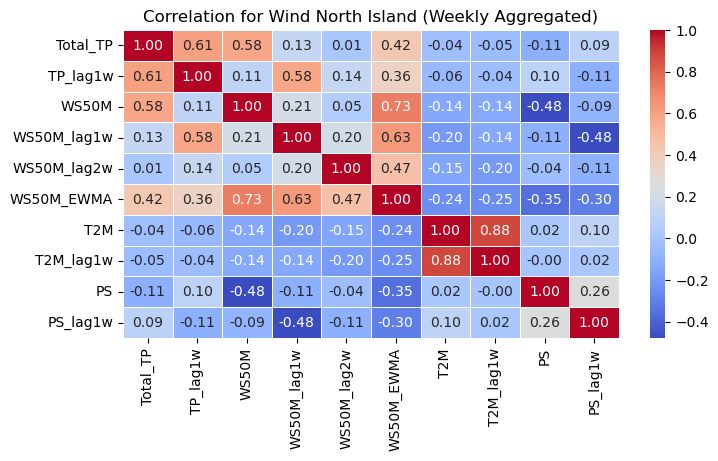

In [64]:
# Compute correlation matrix - North Island
correlation_matrix_wind_wk_lag_north = df_wind_weekly_lagged_north.corr()

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix_wind_wk_lag_north, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation for Wind North Island (Weekly Aggregated)')
plt.show()

In [65]:
# Add 1 to 2-week lagged climate features
df_wind_weekly_south['TP_lag1w'] = df_wind_weekly_south['Total_TP'].shift(1)
df_wind_weekly_south['T2M_lag1w'] = df_wind_weekly_south['T2M'].shift(1)
df_wind_weekly_south['PS_lag1w'] = df_wind_weekly_south['PS'].shift(1)
df_wind_weekly_south['WS50M_lag1w'] = df_wind_weekly_south['WS50M'].shift(1)
df_wind_weekly_south['WS50M_lag2w'] = df_wind_weekly_south['WS50M'].shift(2)
df_wind_weekly_south['WS50M_EWMA'] = df_wind_weekly_south['WS50M'].ewm(alpha=0.3, adjust=False).mean()
#df_hydro_weekly_north['APIxGWETPROF'] = df_hydro_weekly_north['PRECIP_EWMA'] * df_hydro_weekly_north['GWETPROF']

In [66]:
# Retain only lagged + target, drop NA
df_wind_weekly_lagged_south = df_wind_weekly_south[['Total_TP', 'PS', 'T2M', 'WS50M', 'TP_lag1w', 'T2M_lag1w', 'PS_lag1w', 'WS50M_lag1w', 'WS50M_lag2w', 'WS50M_EWMA']].dropna()
df_wind_weekly_lagged_south.head()

,Total_TP,PS,T2M,WS50M,TP_lag1w,T2M_lag1w,PS_lag1w,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA
DATE,,,,,,,,,,
2015-03-22,2.169076e+06,101.260000,11.324286,5.302857,2.755933e+06,13.817143,101.075714,4.945714,6.545714,5.836857
2015-03-29,1.893987e+06,100.988571,13.421429,3.867143,2.169076e+06,11.324286,101.260000,5.302857,4.945714,5.245943
2015-04-05,4.960861e+06,101.465714,13.738571,7.328571,1.893987e+06,13.421429,100.988571,3.867143,5.302857,5.870731
2015-04-12,2.796316e+06,100.537143,11.622857,7.647143,4.960861e+06,13.738571,101.465714,7.328571,3.867143,6.403655
2015-04-19,2.640676e+06,101.004286,9.812857,7.208571,2.796316e+06,11.622857,100.537143,7.647143,7.328571,6.645130


In [67]:
order = ['Total_TP','TP_lag1w','WS50M','WS50M_lag1w','WS50M_lag2w','WS50M_EWMA','T2M','T2M_lag1w','PS','PS_lag1w']
df_wind_weekly_lagged_south = df_wind_weekly_lagged_south[order]

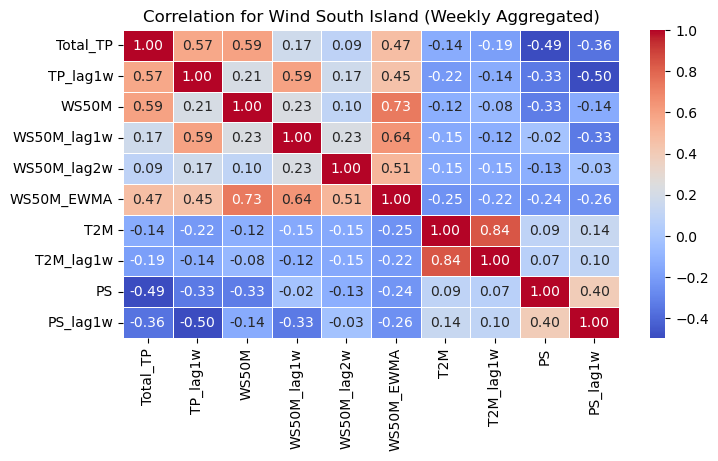

In [68]:
# Compute correlation matrix - South Island
correlation_matrix_wind_wk_lag_south = df_wind_weekly_lagged_south.corr()

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(correlation_matrix_wind_wk_lag_south, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation for Wind South Island (Weekly Aggregated)')
plt.show()

In [69]:
#'Total_TP','WS50M', 'TP_lag1w','WS50M_EWMA'

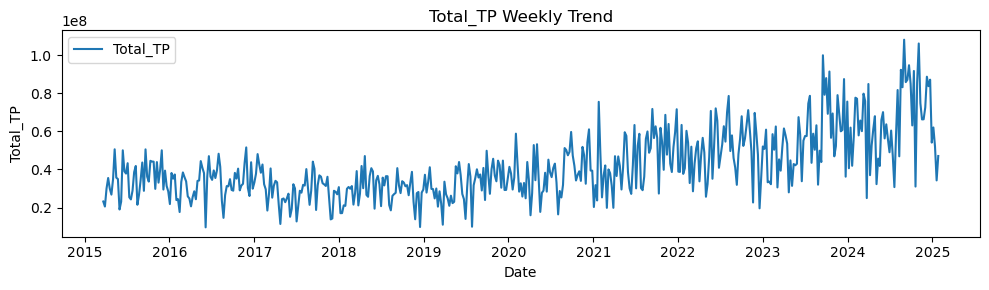

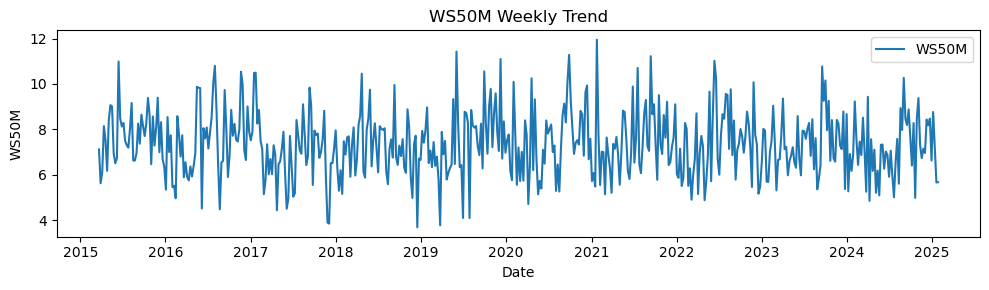

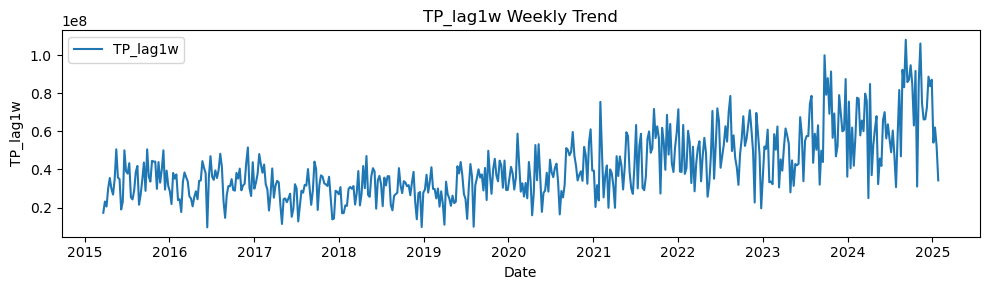

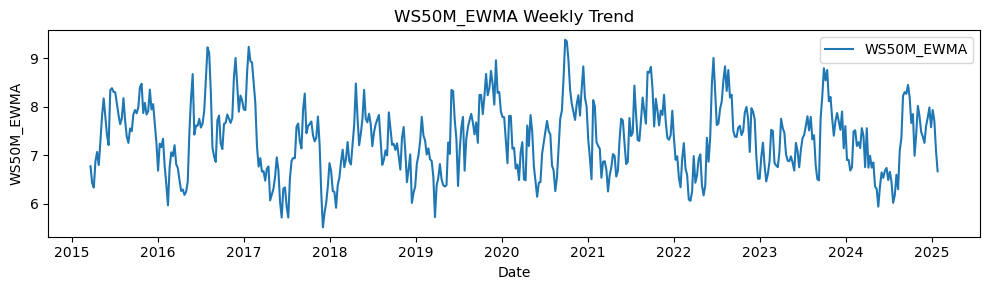

In [70]:
factors = ['Total_TP','WS50M', 'TP_lag1w','WS50M_EWMA']

for f in factors:
    plt.figure(figsize=(10, 3))
    plt.plot(df_wind_weekly_lagged_north[f], label=f)
    plt.title(f'{f} Weekly Trend')
    plt.xlabel('Date')
    plt.ylabel(f)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [71]:
print(df_wind_weekly_south.columns.tolist())

['Total_TP', 'PS', 'T2M', 'WS50M', 'TP_lag1w', 'T2M_lag1w', 'PS_lag1w', 'WS50M_lag1w', 'WS50M_lag2w', 'WS50M_EWMA']


In [72]:
df_wind_weekly_south.head()

,Total_TP,PS,T2M,WS50M,TP_lag1w,T2M_lag1w,PS_lag1w,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA
DATE,,,,,,,,,,
2015-03-08,2.978269e+06,99.881429,13.911429,6.545714,NaN,NaN,NaN,NaN,NaN,6.545714
2015-03-15,2.755933e+06,101.075714,13.817143,4.945714,2.978269e+06,13.911429,99.881429,6.545714,NaN,6.065714
2015-03-22,2.169076e+06,101.260000,11.324286,5.302857,2.755933e+06,13.817143,101.075714,4.945714,6.545714,5.836857
2015-03-29,1.893987e+06,100.988571,13.421429,3.867143,2.169076e+06,11.324286,101.260000,5.302857,4.945714,5.245943
2015-04-05,4.960861e+06,101.465714,13.738571,7.328571,1.893987e+06,13.421429,100.988571,3.867143,5.302857,5.870731


In [73]:
#'Total_TP','WS50M', 'TP_lag1w','WS50M_EWMA'

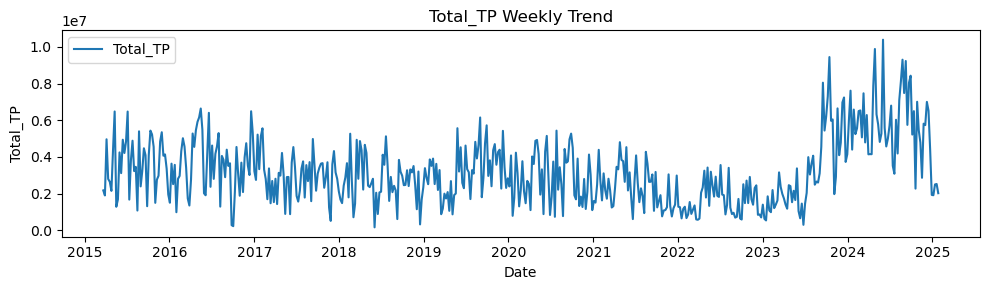

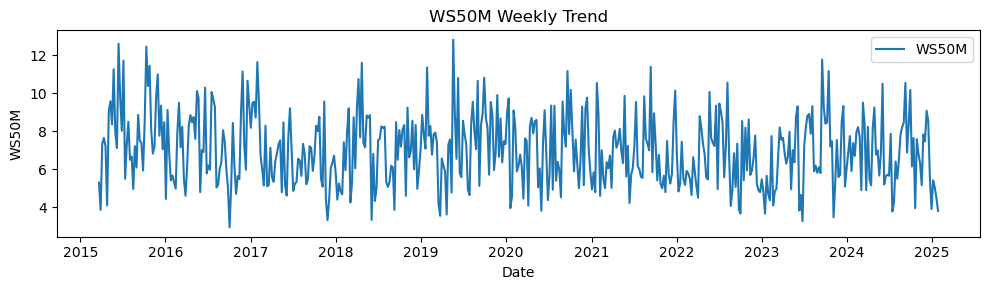

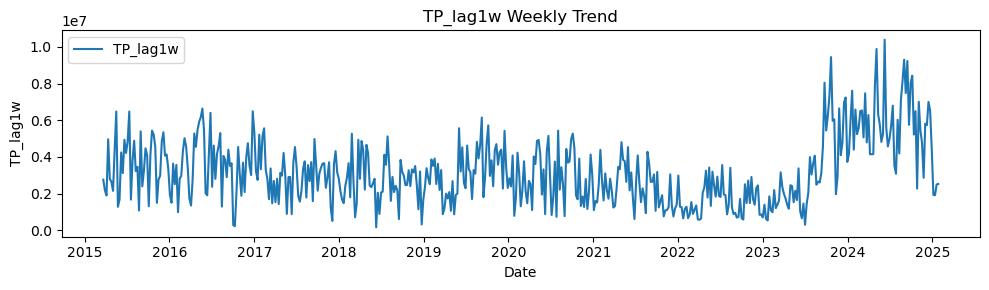

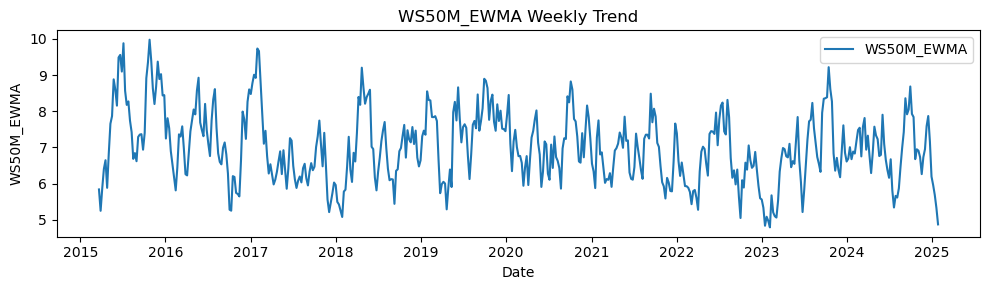

In [74]:
factors = ['Total_TP','WS50M', 'TP_lag1w','WS50M_EWMA']

for f in factors:
    plt.figure(figsize=(10, 3))
    plt.plot(df_wind_weekly_lagged_south[f], label=f)
    plt.title(f'{f} Weekly Trend')
    plt.xlabel('Date')
    plt.ylabel(f)
    plt.legend()
    plt.tight_layout()
    plt.show()

# SARIMA Model- Wind North Island

In [147]:
df_wind_weekly_lagged_north = df_wind_weekly_lagged_north.copy()

In [149]:
df_wind_weekly_lagged_north.head()

,Total_TP,TP_lag1w,WS50M,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA,T2M,T2M_lag1w,PS,PS_lag1w
DATE,,,,,,,,,,
2015-03-22,2.317096e+07,1.724348e+07,7.118980,4.644694,7.480408,6.776480,13.854694,17.476327,99.580612,99.761224
2015-03-29,2.053256e+07,2.317096e+07,5.629796,7.118980,4.644694,6.432474,16.650408,13.854694,99.906531,99.580612
2015-04-05,3.000496e+07,2.053256e+07,6.114286,5.629796,7.118980,6.337018,16.031224,16.650408,100.376327,99.906531
2015-04-12,3.550845e+07,3.000496e+07,8.142449,6.114286,5.629796,6.878647,16.105510,16.031224,99.678367,100.376327
2015-04-19,2.991374e+07,3.550845e+07,7.519388,8.142449,6.114286,7.070869,11.181837,16.105510,99.568980,99.678367


In [151]:
df_wind_weekly_lagged_north.tail()

,Total_TP,TP_lag1w,WS50M,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA,T2M,T2M_lag1w,PS,PS_lag1w
DATE,,,,,,,,,,
2024-12-29,54108854.0,87132781.0,6.629870,8.472468,8.181818,7.581210,16.805844,16.011169,98.810130,99.121169
2025-01-05,62051526.0,54108854.0,8.763896,6.629870,8.472468,7.936016,15.140000,16.805844,98.957403,98.810130
2025-01-12,52101775.0,62051526.0,7.200390,8.763896,6.629870,7.715328,14.214545,15.140000,99.909610,98.957403
2025-01-19,34257081.0,52101775.0,5.665325,7.200390,8.763896,7.100327,15.139870,14.214545,99.968831,99.909610
2025-01-26,47067541.0,34257081.0,5.674156,5.665325,7.200390,6.672476,18.375844,15.139870,99.268312,99.968831


In [153]:
# Frequency setting 'W' (weekly)
df_wind_weekly_lagged_north.head()
df_wind_weekly_lagged_north.index.freq  

<Week: weekday=6>

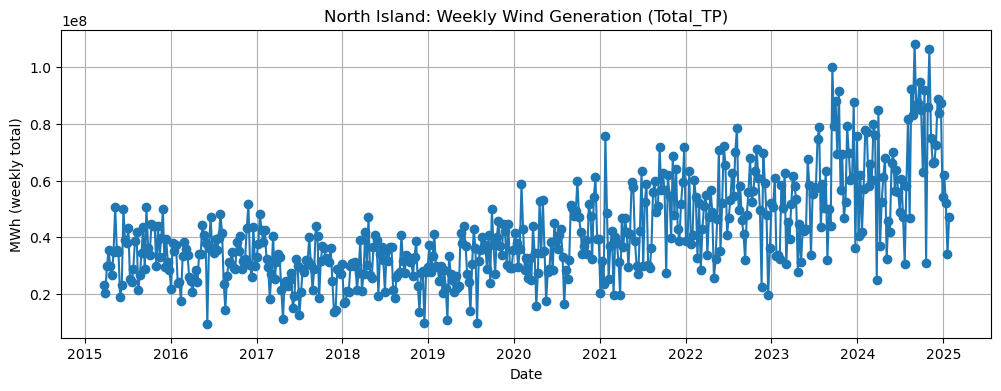

In [155]:
plt.figure(figsize=(12,4))
plt.plot(df_wind_weekly_lagged_north['Total_TP'], marker='o', linestyle='-')
plt.title("North Island: Weekly Wind Generation (Total_TP)")
plt.ylabel("MWh (weekly total)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [157]:
# stationery check for north island weekly data
from statsmodels.tsa.stattools import adfuller

# Assume df_model_for_forecasting has a datetime index and a 'Total_TP' column.
result = adfuller(df_wind_weekly_lagged_north['Total_TP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.804845
p-value: 0.378059
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [159]:
wk_wind_north = df_wind_weekly_lagged_north['Total_TP']
wk_wind_north_diff1 = wk_wind_north.diff()

In [161]:
wk_wind_north_diff1.head()

DATE
2015-03-22             NaN
2015-03-29   -2.638394e+06
2015-04-05    9.472395e+06
2015-04-12    5.503496e+06
2015-04-19   -5.594711e+06
Freq: W-SUN, Name: Total_TP, dtype: float64

In [163]:
wk_wind_north_diff1 = wk_wind_north_diff1.dropna()

In [165]:
# Assume df_model_for_forecasting has a datetime index and a 'Total_TP' column.
result = adfuller(wk_wind_north_diff1)
print('ADF Statistic (1st difference) : %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic (1st difference) : -12.166906
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [167]:
# Assume wk_wind_north is your original weekly wind Series (before differencing):
# Step a) Seasonal-difference (lag=52):
wk_wind_north_seas_diff = wk_wind_north.diff(52).dropna()

In [169]:
# ADF test on only seasonal differencing:
result_seas = adfuller(wk_wind_north_seas_diff)
print('ADF Statistic (seasonal diff): %f' % result_seas[0])
print('p-value: %f' % result_seas[1])
print('Critical Values:')
for key, value in result_seas[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic (seasonal diff): -4.185813
p-value: 0.000696
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [171]:
# Step b) Combined first + seasonal differencing:
wk_wind_north_diff1_seas = wk_wind_north.diff().diff(52).dropna()
result_combo = adfuller(wk_wind_north_diff1_seas)
print('ADF Statistic (d=1, D=1): %f' % result_combo[0])
print('p-value: %f' % result_combo[1])
print('Critical Values:')
for key, value in result_combo[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic (d=1, D=1): -11.024275
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


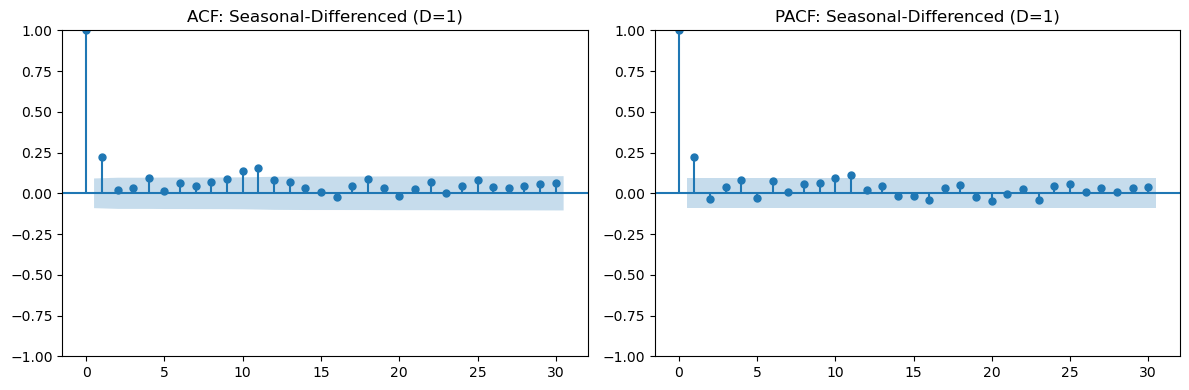

In [173]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plot_acf(wk_wind_north_seas_diff, lags=30, ax=plt.gca())
plt.title("ACF: Seasonal-Differenced (D=1)")

plt.subplot(1,2,2)
plot_pacf(wk_wind_north_seas_diff, lags=30, ax=plt.gca())
plt.title("PACF: Seasonal-Differenced (D=1)")

plt.tight_layout()
plt.show()

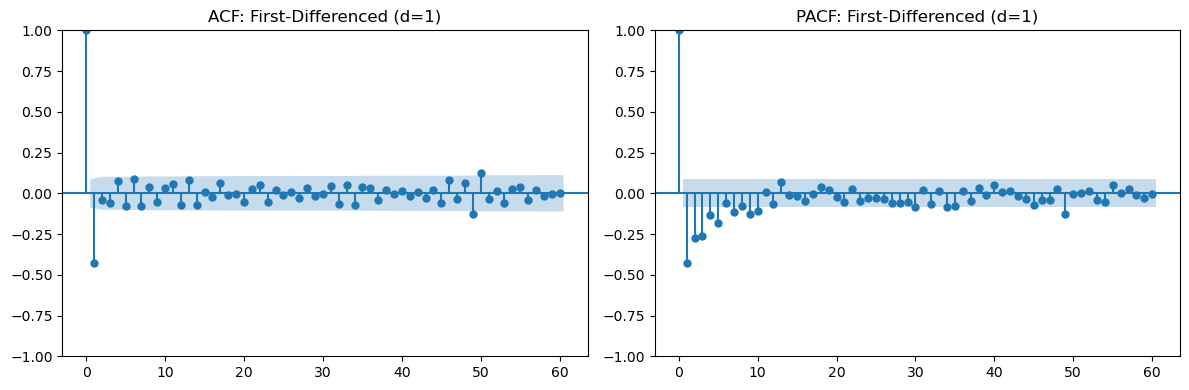

In [175]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plot_acf(wk_wind_north_diff1, lags=60, ax=plt.gca())
plt.title("ACF: First‐Differenced (d=1)")

plt.subplot(1,2,2)
plot_pacf(wk_wind_north_diff1, lags=60, ax=plt.gca())
plt.title("PACF: First‐Differenced (d=1)")

plt.tight_layout()
plt.show()

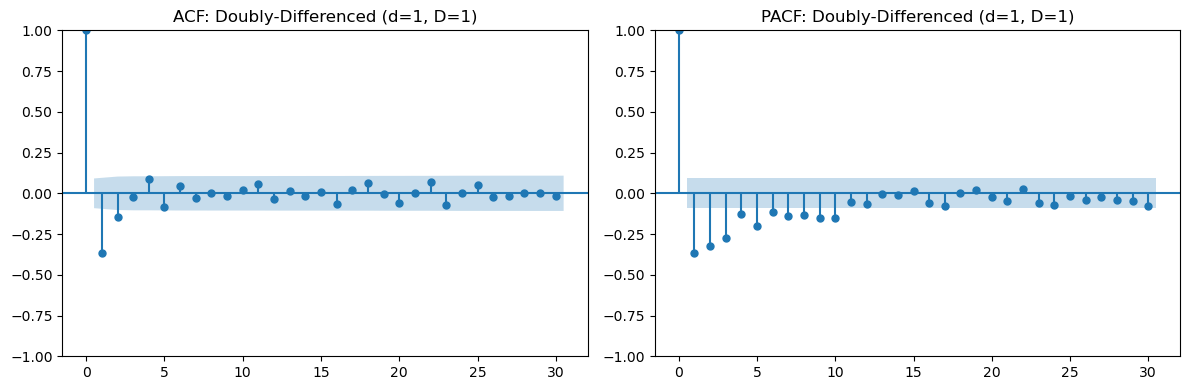

In [177]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plot_acf(wk_wind_north_diff1_seas, lags=30, ax=plt.gca())
plt.title("ACF: Doubly-Differenced (d=1, D=1)")

plt.subplot(1,2,2)
plot_pacf(wk_wind_north_diff1_seas, lags=30, ax=plt.gca())
plt.title("PACF: Doubly-Differenced (d=1, D=1)")

plt.tight_layout()
plt.show()

In [179]:
# Check for rows where Total_TP equals 0.0
zero_records = df_wind_weekly_lagged_north[df_wind_weekly_lagged_north['Total_TP'] == 0.0]
print("Number of weekly records with Total_TP equal to 0:", len(zero_records))
print(zero_records)

Number of weekly records with Total_TP equal to 0: 0
Empty DataFrame
Columns: [Total_TP, TP_lag1w, WS50M, WS50M_lag1w, WS50M_lag2w, WS50M_EWMA, T2M, T2M_lag1w, PS, PS_lag1w]
Index: []


In [181]:
df_wind_weekly_lagged_north

,Total_TP,TP_lag1w,WS50M,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA,T2M,T2M_lag1w,PS,PS_lag1w
DATE,,,,,,,,,,
2015-03-22,2.317096e+07,1.724348e+07,7.118980,4.644694,7.480408,6.776480,13.854694,17.476327,99.580612,99.761224
2015-03-29,2.053256e+07,2.317096e+07,5.629796,7.118980,4.644694,6.432474,16.650408,13.854694,99.906531,99.580612
2015-04-05,3.000496e+07,2.053256e+07,6.114286,5.629796,7.118980,6.337018,16.031224,16.650408,100.376327,99.906531
2015-04-12,3.550845e+07,3.000496e+07,8.142449,6.114286,5.629796,6.878647,16.105510,16.031224,99.678367,100.376327
2015-04-19,2.991374e+07,3.550845e+07,7.519388,8.142449,6.114286,7.070869,11.181837,16.105510,99.568980,99.678367
...,...,...,...,...,...,...,...,...,...,...
2024-12-29,5.410885e+07,8.713278e+07,6.629870,8.472468,8.181818,7.581210,16.805844,16.011169,98.810130,99.121169
2025-01-05,6.205153e+07,5.410885e+07,8.763896,6.629870,8.472468,7.936016,15.140000,16.805844,98.957403,98.810130
2025-01-12,5.210178e+07,6.205153e+07,7.200390,8.763896,6.629870,7.715328,14.214545,15.140000,99.909610,98.957403


In [183]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_wind_weekly_lagged_north)
train_size = int(n * 0.8)
train_wk_north = df_wind_weekly_lagged_north.iloc[:train_size]
test_wk_north = df_wind_weekly_lagged_north.iloc[train_size:]

In [185]:
print("Daily Train set:", train_wk_north.index.min(), "to", train_wk_north.index.max())
print("Daily Test set:", test_wk_north.index.min(), "to", test_wk_north.index.max())

Daily Train set: 2015-03-22 00:00:00 to 2023-02-05 00:00:00
Daily Test set: 2023-02-12 00:00:00 to 2025-01-26 00:00:00


In [187]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_wk_north['Total_TP']
target_test = test_wk_north['Total_TP']


In [189]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                #exog=exog_train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Total_TP   No. Observations:                  412
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -5414.752
Date:                            Thu, 05 Jun 2025   AIC                          10839.504
Time:                                    10:45:40   BIC                          10858.105
Sample:                                03-22-2015   HQIC                         10846.944
                                     - 02-05-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1563      0.131      1.192      0.233      -0.101       0.413
ma.L1         -0.8477      0.074   

In [190]:
# Forecast on the test set - non log
n_steps = len(target_test)
#forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [193]:
sarima_fc_obj = results.get_forecast(steps=n_steps)
forecast   = sarima_fc_obj.predicted_mean

In [195]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

#print("\nForecast Performance Metrics (Without Log Transformation):")
# print(f"RMSE: {rmse:.2f}")
# print(f"MAE: {mae:.2f}")
# print(f"Adjusted MAPE: {mape:.2f}%")
print("North Island Wind SARIMA(1, 1, 1)x(1, 1, 1, 52) → MAE:", f"{mae:.2f}",
      "RMSE:", f"{rmse:.2f}", "MAPE:", f"{mape:.2f}%")

North Island Wind SARIMA(1, 1, 1)x(1, 1, 1, 52) → MAE: 15327431.38 RMSE: 18517114.43 MAPE: 27.56%


In [198]:
###############################################################################################3

In [200]:
### ANN for comparison ###

#   Set seeds for reproducibility  
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# 2) Data prep (no randomness here, aside from ’shift’ which is deterministic)
df_ann_wind_north_wk = df_wind_weekly_lagged_north[['Total_TP','TP_lag1w']]

n_wind_ann     = len(df_ann_wind_north_wk)
split_ann = int(n_wind_ann * 0.8)

train_n_ann = df_ann_wind_north_wk.iloc[:split_ann]
test_n_ann  = df_ann_wind_north_wk.iloc[split_ann:]

X_train = train_n_ann[['TP_lag1w']].values
y_train = train_n_ann['Total_TP'].values.reshape(-1,1)
X_test  = test_n_ann[['TP_lag1w']].values
y_test  = test_n_ann['Total_TP'].values.reshape(-1,1)


# 3) Scaling
scaler_X = MinMaxScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_test_s  = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_s = scaler_y.fit_transform(y_train)
# (We hold off on transforming y_test because we want raw y_test for metrics.)

# 4) Build the ANN
model_ann = Sequential([
    Dense(16, activation='relu', input_shape=(1,)),
    Dense(8,  activation='relu'),
    Dense(1)
])
model_ann.compile(optimizer='adam', loss='mse')

# 5) Train the ANN (the shuffle order is now deterministic)
history = model_ann.fit(
    X_train_s, y_train_s,
    epochs=100,
    batch_size=16,
    validation_split=0.05,
    verbose=0
)

# 6) Predict & rescale
y_pred_s = model_ann.predict(X_test_s)
y_pred   = scaler_y.inverse_transform(y_pred_s).flatten()

# 7) Metrics on raw scale
mae_ann  = mean_absolute_error(y_test.flatten(), y_pred)
rmse_ann = np.sqrt(mean_squared_error(y_test.flatten(), y_pred))
mape_ann = np.mean(np.abs((y_test.flatten() - y_pred) / y_test.flatten())) * 100

print(f"North Island (without regressors) - Wind - ANN - MAE: {mae_ann:.2f}, RMSE: {rmse_ann:.2f}, MAPE: {mape_ann:.2f}%")



C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
North Island (without regressors) - Wind - ANN - MAE: 19554300.14, RMSE: 23627402.89, MAPE: 30.94%


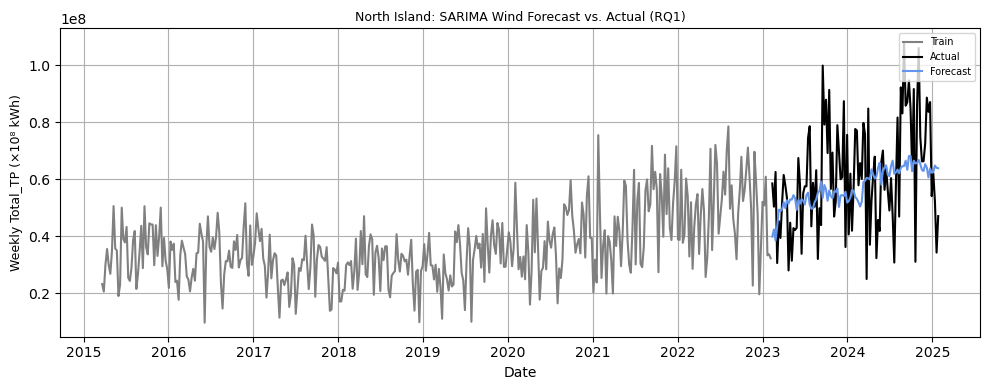

In [199]:
# 1. Obtain the forecast object from the fitted results:
n_steps = len(target_test)
fc_n = results.get_forecast(steps=n_steps)  
# If you used exogenous variables when fitting, replace with:
# fc_n = results_n.get_forecast(steps=n_steps, exog=exog_test)

# 2. Extract the predicted mean and confidence intervals:
forecast = fc_n.predicted_mean
conf_int = fc_n.conf_int()

# 3. Plot train, actual, forecast, and CI:
plt.figure(figsize=(10, 4))

plt.plot(train_wk_north.index, target_train, label="Train", color="gray")
plt.plot(test_wk_north.index,  target_test,  label="Actual", color="black")
plt.plot(forecast.index,       forecast,     label="Forecast", color="cornflowerblue")

# plt.fill_between(
#     conf_int.index,
#     conf_int.iloc[:, 0],  # lower bound
#     conf_int.iloc[:, 1],  # upper bound
#     color="lightblue",
#     alpha=0.2
# )

plt.legend()
plt.title("North Island: SARIMA Wind Forecast vs. Actual (RQ1)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.legend(loc="upper right", fontsize=7)
plt.tight_layout()
plt.show()

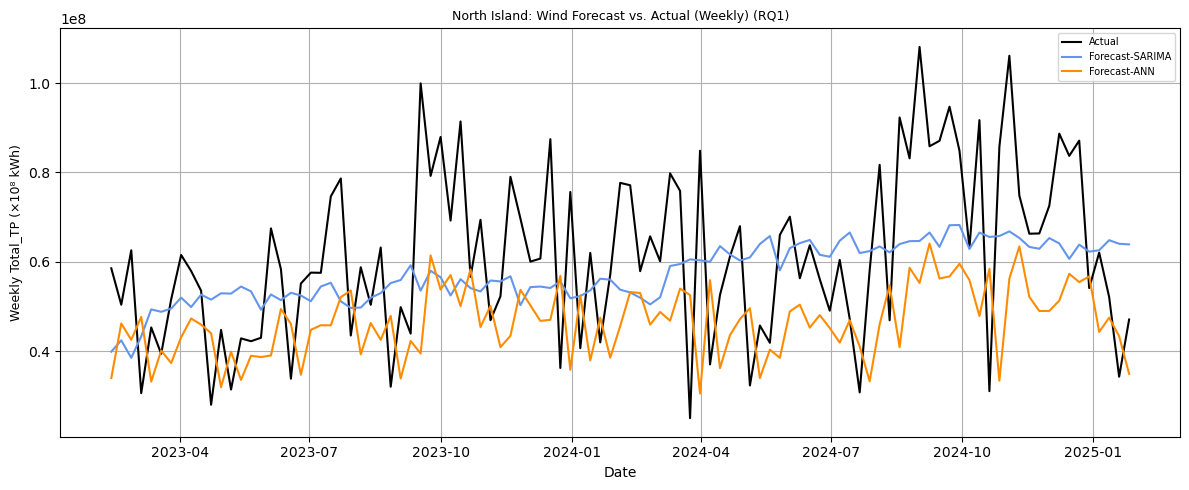

In [202]:
# 1. Obtain the forecast object from the fitted results:
n_steps = len(target_test)
fc_n = results.get_forecast(steps=n_steps)  
# If you used exogenous variables when fitting, replace with:
# fc_n = results_n.get_forecast(steps=n_steps, exog=exog_test)

# 2. Extract the predicted mean and confidence intervals:
forecast = fc_n.predicted_mean
conf_int = fc_n.conf_int()

# 3. Plot train, actual, forecast, and CI:
plt.figure(figsize=(12, 5))

#plt.plot(train_wk_north.index, target_train, label="Train", color="gray")
plt.plot(test_wk_north.index,  target_test,  label="Actual", color="black")
plt.plot(forecast.index,       forecast,     label="Forecast-SARIMA", color="cornflowerblue")
plt.plot(test_n_ann.index, y_pred, label="Forecast-ANN",      color="darkorange")

# plt.fill_between(
#     conf_int.index,
#     conf_int.iloc[:, 0],  # lower bound
#     conf_int.iloc[:, 1],  # upper bound
#     color="lightblue",
#     alpha=0.2
# )

plt.legend()
plt.title("North Island: Wind Forecast vs. Actual (Weekly) (RQ1)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.legend(loc="upper right", fontsize=7)
plt.tight_layout()
plt.show()

In [204]:
#exog_cols = ['WS50M']
#exog_cols = ['WS50M']
#exog_cols = ['WS50M']
#exog_cols = ['WS50M', 'TP_lag1w']
exog_cols = ['WS50M', 'TP_lag1w','WS50M_EWMA']

In [206]:
exog_train = train_wk_north[exog_cols]
exog_test = test_wk_north[exog_cols]

In [208]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                exog=exog_train,
                order=(1, 1, 1),
                seasonal_order=(1, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Total_TP   No. Observations:                  412
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 52)   Log Likelihood               -5224.910
Date:                            Thu, 05 Jun 2025   AIC                          10465.821
Time:                                    10:48:50   BIC                          10495.583
Sample:                                03-22-2015   HQIC                         10477.725
                                     - 02-05-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
WS50M       4.631e+06   3.26e+05     14.210      0.000    3.99e+06    5.27e+06
TP_lag1w      -0.1111      0.067   

In [209]:
# Forecast on the test set - non log
n_steps = len(target_test)
forecast = results.get_forecast(steps=n_steps, exog=exog_test).predicted_mean

In [212]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

#print("\nForecast Performance Metrics (Without Log Transformation):")
# print(f"RMSE: {rmse:.2f}")
# print(f"MAE: {mae:.2f}")
# print(f"Adjusted MAPE: {mape:.2f}%")
print("North Island Wind SARIMA(1, 1, 1)x(1, 1, 1, 52) → MAE:", f"{mae:.2f}",
      "RMSE:", f"{rmse:.2f}", "MAPE:", f"{mape:.2f}%")

North Island Wind SARIMA(1, 1, 1)x(1, 1, 1, 52) → MAE: 16529623.91 RMSE: 20181284.62 MAPE: 24.38%


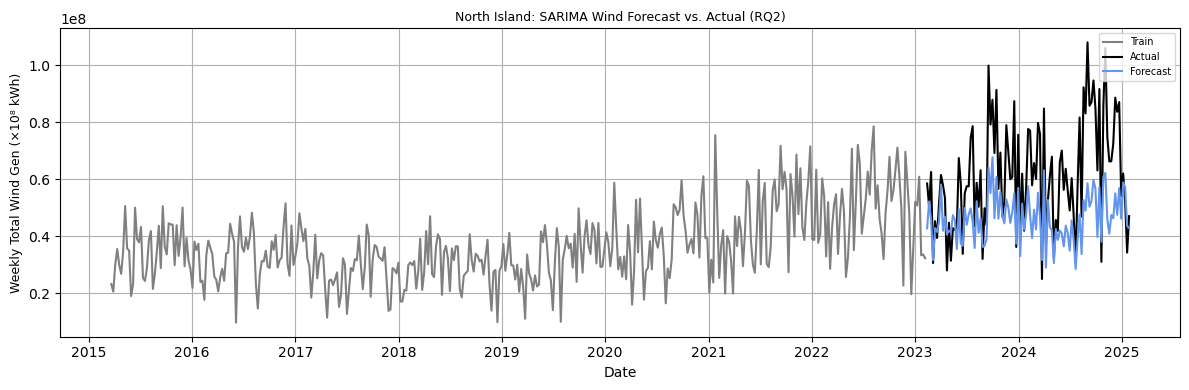

In [214]:
# 1. Obtain the forecast object from the fitted results:
n_steps = len(target_test)
#fc_n = results.get_forecast(steps=n_steps)  
# If you used exogenous variables when fitting, replace with:
fc_n = results.get_forecast(steps=n_steps, exog=exog_test)

# 2. Extract the predicted mean and confidence intervals:
forecast = fc_n.predicted_mean
conf_int = fc_n.conf_int()

# 3. Plot train, actual, forecast, and CI:
plt.figure(figsize=(12, 4))

plt.plot(train_wk_north.index, target_train, label="Train", color="gray")
plt.plot(test_wk_north.index,  target_test,  label="Actual", color="black")
plt.plot(forecast.index,       forecast,     label="Forecast", color="cornflowerblue")

# plt.fill_between(
#     conf_int.index,
#     conf_int.iloc[:, 0],  # lower bound
#     conf_int.iloc[:, 1],  # upper bound
#     color="lightblue",
#     alpha=0.2
# )

# plt.legend()
# plt.title("North Island: SARIMA Wind Forecast vs. Actual (RQ2)")
# plt.xlabel("Date")
# plt.ylabel("Weekly Total_TP (×10⁸ kWh)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

plt.legend()
plt.title("North Island: SARIMA Wind Forecast vs. Actual (RQ2)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total Wind Gen (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.legend(loc="upper right", fontsize=7)
plt.tight_layout()
plt.show()

In [216]:
import pandas as pd
import numpy as np
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# -----------------------------------------------------------------------------
# ASSUMPTIONS / PREDEFINED:
# -----------------------------------------------------------------------------
# • df_wind_weekly_lagged_north : pandas.DataFrame indexed by a weekly DateTimeIndex,
#      containing at least these columns:
#        – 'Total_TP'       (target series, e.g. weekly North‐Island wind output in kWh)
#        – 'WS50M'          (wind speed at 50 m)
#        – 'TP_lag1w'       (Total_TP lagged by one week)
#        – 'WS50M_EWMA'     (EWMA of WS50M)
# -----------------------------------------------------------------------------

# 1) Define the three candidate factors for North Island:
factors_north = ['WS50M', 'TP_lag1w', 'WS50M_EWMA']

# 2) Train/test split (80/20)
n = len(df_wind_weekly_lagged_north)
split_idx = int(n * 0.8)

train_df_north = df_wind_weekly_lagged_north.iloc[:split_idx].copy()
test_df_north  = df_wind_weekly_lagged_north.iloc[split_idx:].copy()

# 3) Extract raw X and y for train/test
X_train_raw_north = train_df_north[factors_north].values
X_test_raw_north  = test_df_north[factors_north].values
y_train_raw_north = train_df_north['Total_TP'].values.reshape(-1, 1)
y_test_raw_north  = test_df_north['Total_TP'].values.reshape(-1, 1)

# 4) Scale X and y
x_scaler_north = StandardScaler().fit(X_train_raw_north)
y_scaler_north = StandardScaler().fit(y_train_raw_north)

X_train_north = x_scaler_north.transform(X_train_raw_north)
X_test_north  = x_scaler_north.transform(X_test_raw_north)
y_train_north = y_scaler_north.transform(y_train_raw_north)
y_test_north  = y_scaler_north.transform(y_test_raw_north)

# 5) Sanity‐check shapes
print("X_train_north:", X_train_north.shape, "y_train_north:", y_train_north.shape)
print("X_test_north: ", X_test_north.shape,  "y_test_north: ", y_test_north.shape)

# 6) Build the ANN (with an explicit Input layer)
def build_ann(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128),
        BatchNormalization(),
        LeakyReLU(negative_slope=0.1),
        Dropout(0.2),

        Dense(64),
        BatchNormalization(),
        LeakyReLU(negative_slope=0.1),
        Dropout(0.2),

        Dense(32),
        BatchNormalization(),
        LeakyReLU(negative_slope=0.1),

        Dense(1)  # linear output for regression
    ])
    return model

# 7) Instantiate and compile the model
opt = tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)
model_north = build_ann(X_train_north.shape[1])
model_north.compile(
    optimizer=opt,
    loss=Huber(delta=0.5),
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='mape')]
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# 8) Train (use 10% of train_df_north as internal validation, keep test_df_north fully unseen)
history_north = model_north.fit(
    X_train_north, y_train_north,
    validation_split=0.10,
    epochs=200,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

# 9) Predict & inverse‐scale
y_pred_scaled_north = model_north.predict(X_test_north)
y_pred_north = y_scaler_north.inverse_transform(y_pred_scaled_north).ravel()
y_true_north = y_scaler_north.inverse_transform(y_test_north).ravel()

# 10) Compute metrics
mae_north  = mean_absolute_error(y_true_north, y_pred_north)
rmse_north = np.sqrt(mean_squared_error(y_true_north, y_pred_north))
mape_north = mean_absolute_percentage_error(y_true_north, y_pred_north) * 100

print(f"RQ2: North Island (with regressors) - Wind - ANN - "
      f"MAE: {mae_north:.2f}, RMSE: {rmse_north:.2f}, MAPE: {mape_north:.2f}%")


X_train_north: (412, 3) y_train_north: (412, 1)
X_test_north:  (103, 3) y_test_north:  (103, 1)
Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.3563 - mape: 337.1682 - val_loss: 0.5303 - val_mape: 95.7793 - learning_rate: 5.0000e-04
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2009 - mape: 277.8963 - val_loss: 0.4854 - val_mape: 97.2012 - learning_rate: 5.0000e-04
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1904 - mape: 261.9849 - val_loss: 0.4830 - val_mape: 95.8923 - learning_rate: 5.0000e-04
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1761 - mape: 212.4400 - val_loss: 0.4772 - val_mape: 99.6821 - learning_rate: 5.0000e-04
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1758 - mape: 330.2200 - val_loss: 0.4735 - val_mape: 102.3145 - learning_rate: 5.0000e-04
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1480 - mape: 211.1255 - val_loss: 0.4705 - val_mape: 103.2370 - learning_rate: 5.0000e-04
E

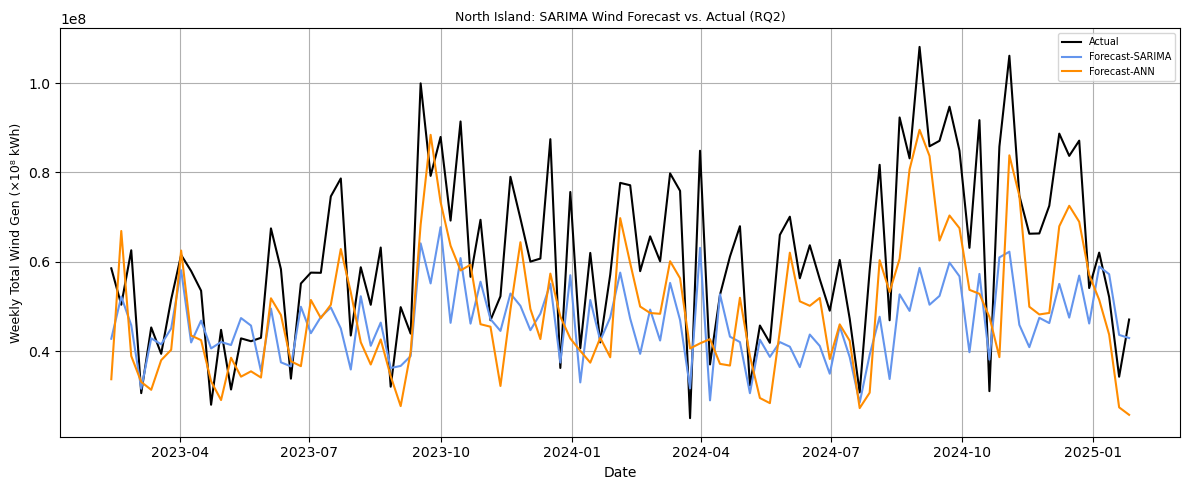

In [220]:
# 1. Obtain the forecast object from the fitted results:
n_steps = len(target_test)
#fc_n = results.get_forecast(steps=n_steps)  
# If you used exogenous variables when fitting, replace with:
fc_n = results.get_forecast(steps=n_steps, exog=exog_test)

# 2. Extract the predicted mean and confidence intervals:
forecast = fc_n.predicted_mean
conf_int = fc_n.conf_int()

# 3. Plot train, actual, forecast, and CI:
plt.figure(figsize=(12, 5))

#plt.plot(train_wk_north.index, target_train, label="Train", color="gray")
plt.plot(test_wk_north.index,  target_test,  label="Actual", color="black")
plt.plot(forecast.index,       forecast,     label="Forecast-SARIMA", color="cornflowerblue")
plt.plot(test_df_north.index,y_pred_north,label="Forecast-ANN", color="darkorange")

# plt.fill_between(
#     conf_int.index,
#     conf_int.iloc[:, 0],  # lower bound
#     conf_int.iloc[:, 1],  # upper bound
#     color="lightblue",
#     alpha=0.2
# )

# plt.legend()
# plt.title("North Island: SARIMA Wind Forecast vs. Actual (RQ2)")
# plt.xlabel("Date")
# plt.ylabel("Weekly Total_TP (×10⁸ kWh)")
# plt.grid(True)
# plt.tight_layout()
# plt.show()

plt.legend()
plt.title("North Island: SARIMA Wind Forecast vs. Actual (RQ2)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total Wind Gen (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.legend(loc="upper right", fontsize=7)
plt.tight_layout()
plt.show()

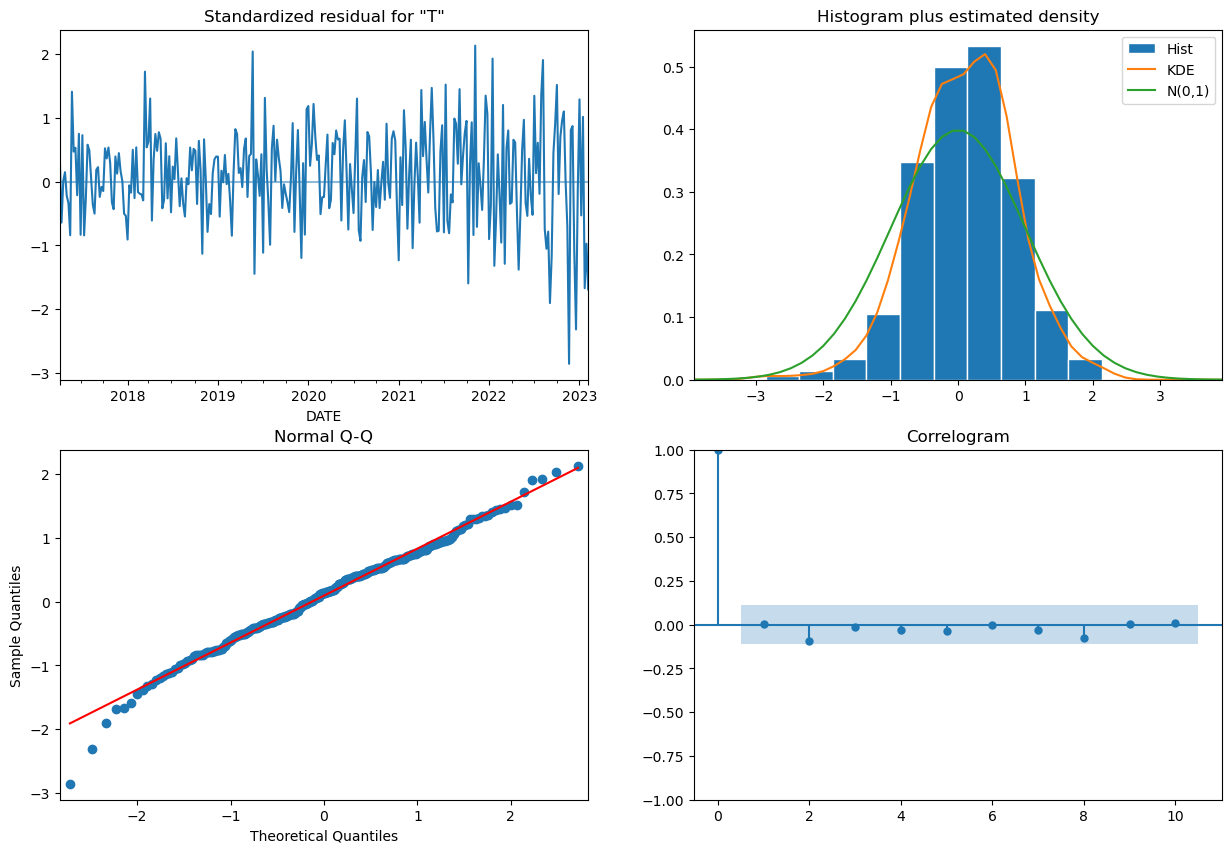

In [291]:
results.plot_diagnostics(figsize=(15, 10))
plt.show()

### South Island - Wind Weekly analysis

In [222]:
print(df_wind_weekly_lagged_south.shape)


(515, 10)


In [224]:
df_wind_weekly_lagged_south.head()

,Total_TP,TP_lag1w,WS50M,WS50M_lag1w,WS50M_lag2w,WS50M_EWMA,T2M,T2M_lag1w,PS,PS_lag1w
DATE,,,,,,,,,,
2015-03-22,2.169076e+06,2.755933e+06,5.302857,4.945714,6.545714,5.836857,11.324286,13.817143,101.260000,101.075714
2015-03-29,1.893987e+06,2.169076e+06,3.867143,5.302857,4.945714,5.245943,13.421429,11.324286,100.988571,101.260000
2015-04-05,4.960861e+06,1.893987e+06,7.328571,3.867143,5.302857,5.870731,13.738571,13.421429,101.465714,100.988571
2015-04-12,2.796316e+06,4.960861e+06,7.647143,7.328571,3.867143,6.403655,11.622857,13.738571,100.537143,101.465714
2015-04-19,2.640676e+06,2.796316e+06,7.208571,7.647143,7.328571,6.645130,9.812857,11.622857,101.004286,100.537143


In [226]:
# Find rows with zero Total_TP in South Island
zero_tp_south = df_wind_weekly_lagged_south[df_wind_weekly_lagged_south['Total_TP'] == 0]

# Get the unique dates
zero_dates = zero_tp_south.index.unique()

# Display the result
print("Dates with Total_TP = 0 in South Island:")
for date in zero_dates:
    print(date.strftime('%Y-%m-%d'))

Dates with Total_TP = 0 in South Island:


In [228]:
# stationery check for north island daily data
from statsmodels.tsa.stattools import adfuller

# Assume df_model_for_forecasting has a datetime index and a 'Total_TP' column.
result = adfuller(df_wind_weekly_lagged_south['Total_TP'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.812568
p-value: 0.056501
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [230]:
# 2a. Compute first‐difference (lag = 1 week):
diff1_w = df_wind_weekly_lagged_south['Total_TP'].diff().dropna()

# 2b. ADF on the first‐differenced series:
result_d1 = adfuller(diff1_w)
print("ADF Statistic (d=1): %f" % result_d1[0])
print("p-value: %f" % result_d1[1])
print("Critical Values:")
for key, value in result_d1[4].items():
    print(f"\t{key}: {value:.3f}")

ADF Statistic (d=1): -11.206374
p-value: 0.000000
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [232]:
# 3a. Compute seasonal‐difference (lag = 52 weeks):
seas_w = df_wind_weekly_lagged_south['Total_TP'].diff(52).dropna()

# 3b. ADF on the seasonal‐only differenced series:
result_D1 = adfuller(seas_w)
print("ADF Statistic (D=1): %f" % result_D1[0])
print("p-value: %f" % result_D1[1])
print("Critical Values:")
for key, value in result_D1[4].items():
    print(f"\t{key}: {value:.3f}")

ADF Statistic (D=1): -2.454884
p-value: 0.126841
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


In [234]:
# 4a. Apply both differences:
diff1_seas_w = diff1_w.diff(52).dropna()

# 4b. ADF on combined differenced series:
result_combo = adfuller(diff1_seas_w)
print("ADF Statistic (d=1, D=1): %f" % result_combo[0])
print("p-value: %f" % result_combo[1])
print("Critical Values:")
for key, value in result_combo[4].items():
    print(f"\t{key}: {value:.3f}")

ADF Statistic (d=1, D=1): -10.074790
p-value: 0.000000
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570


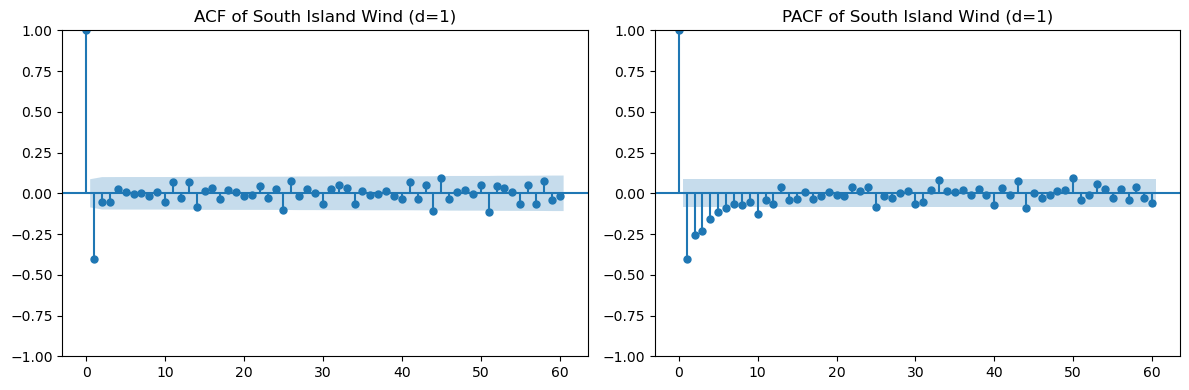

In [236]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 2a. Create the once‐differenced series
diff1_s = df_wind_weekly_lagged_south['Total_TP'].diff().dropna()

# 2b. Plot its ACF and PACF
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_acf(diff1_s, lags=60, ax=plt.gca())
plt.title("ACF of South Island Wind (d=1)")

plt.subplot(1, 2, 2)
plot_pacf(diff1_s, lags=60, ax=plt.gca())
plt.title("PACF of South Island Wind (d=1)")

plt.tight_layout()
plt.show()

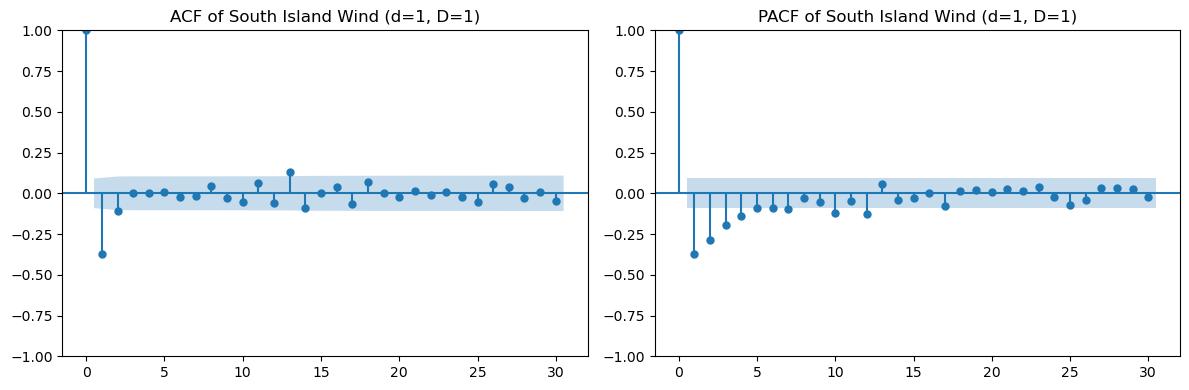

In [238]:
# 3a. Create the doubly‐differenced series
diff1_seas_s = diff1_s.diff(52).dropna()

# 3b. Plot ACF and PACF
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plot_acf(diff1_seas_s, lags=30, ax=plt.gca())
plt.title("ACF of South Island Wind (d=1, D=1)")

plt.subplot(1, 2, 2)
plot_pacf(diff1_seas_s, lags=30, ax=plt.gca())
plt.title("PACF of South Island Wind (d=1, D=1)")

plt.tight_layout()
plt.show()

In [240]:
# Split the weekly data into 80% training and 20% testing sets
n = len(df_wind_weekly_lagged_south)
train_size = int(n * 0.8)
train_weekly = df_wind_weekly_lagged_south.iloc[:train_size]
test_weekly = df_wind_weekly_lagged_south.iloc[train_size:]

In [242]:
print("Weekly Train set:", train_weekly.index.min(), "to", train_weekly.index.max())
print("Weekly Test set:", test_weekly.index.min(), "to", test_weekly.index.max())

Weekly Train set: 2015-03-22 00:00:00 to 2023-02-05 00:00:00
Weekly Test set: 2023-02-12 00:00:00 to 2025-01-26 00:00:00


In [244]:
# Define the target variable (original Total_TP) and exogenous variables
# target_train_log = train_weekly['Total_TP_log']
# target_test_log = test_weekly['Total_TP_log']

target_train = train_weekly['Total_TP']
target_test = test_weekly['Total_TP']


In [246]:
# Fit SARIMAX on the original (non-log) target data
model = SARIMAX(target_train,
                #exog=exog_train,
                order=(0, 1, 1),
                seasonal_order=(0, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results = model.fit(disp=False)
print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Total_TP   No. Observations:                  412
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -4746.772
Date:                            Thu, 05 Jun 2025   AIC                           9499.544
Time:                                    10:52:22   BIC                           9510.705
Sample:                                03-22-2015   HQIC                          9504.008
                                     - 02-05-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8038      0.075    -10.744      0.000      -0.950      -0.657
ma.S.L52      -0.9415      0.061   

In [248]:
# Forecast on the test set - non log
n_steps = len(test_weekly)
forecast = results.get_forecast(steps=n_steps).predicted_mean

In [250]:
# Compute performance metrics - non log
rmse = np.sqrt(mean_squared_error(target_test, forecast))
mae = mean_absolute_error(target_test, forecast)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast) / (target_test + epsilon))) * 100

# print("\nForecast Performance Metrics (Without Log Transformation):")
# print(f"RMSE: {rmse:.2f}")
# print(f"MAE: {mae:.2f}")
# print(f"Adjusted MAPE: {mape:.2f}%")
print("South Island Wind SARIMA(0, 1, 1)x(0, 1, 1, 52) → MAE:", f"{mae:.2f}",
      "RMSE:", f"{rmse:.2f}", "MAPE:", f"{mape:.2f}%")

South Island Wind SARIMA(0, 1, 1)x(0, 1, 1, 52) → MAE: 2424660.49 RMSE: 3044829.16 MAPE: 54.33%


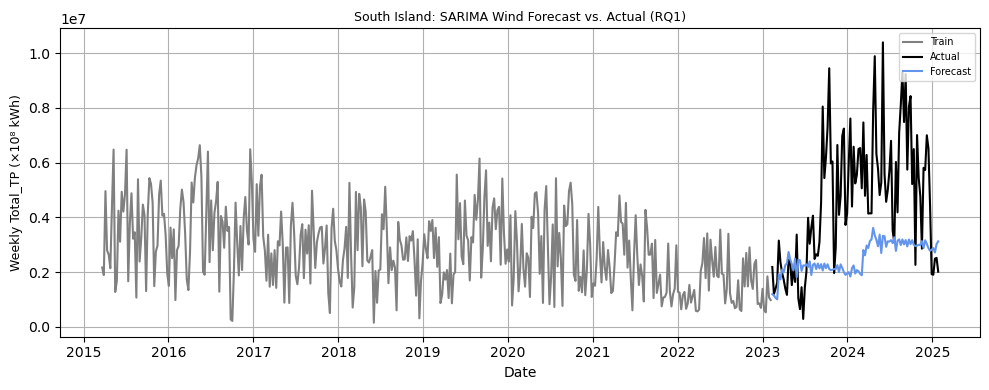

In [252]:
# # Plot Actual vs. Forecast
# plt.figure(figsize=(14, 7))
# plt.plot(train_weekly.index, target_train, label='Train', color='blue')
# plt.plot(test_weekly.index, target_test, label='Test', color='green')
# plt.plot(test_weekly.index, forecast, label='Forecast', color='red', linestyle='--')
# plt.xlabel("Date")
# plt.ylabel("Total_TP")
# plt.title("Daily SARIMAX Forecast-North Island (Without Log Transformation)")
# plt.legend()
# plt.tight_layout()
# plt.show()

# 1. Obtain the forecast object from the fitted results:
n_steps = len(target_test)
fc_n = results.get_forecast(steps=n_steps)  
# If you used exogenous variables when fitting, replace with:
# fc_n = results_n.get_forecast(steps=n_steps, exog=exog_test)

# 2. Extract the predicted mean and confidence intervals:
forecast = fc_n.predicted_mean
conf_int = fc_n.conf_int()

# 3. Plot train, actual, forecast, and CI:
plt.figure(figsize=(10, 4))

plt.plot(train_weekly.index, target_train, label="Train", color="gray")
plt.plot(test_weekly.index,  target_test,  label="Actual", color="black")
plt.plot(forecast.index,       forecast,     label="Forecast", color="cornflowerblue")

# plt.fill_between(
#     conf_int.index,
#     conf_int.iloc[:, 0],  # lower bound
#     conf_int.iloc[:, 1],  # upper bound
#     color="lightblue",
#     alpha=0.2
# )

plt.legend()
plt.title("South Island: SARIMA Wind Forecast vs. Actual (RQ1)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.legend(loc="upper right", fontsize=7)
plt.tight_layout()
plt.show()

In [254]:
# 2) Data prep (no randomness here, aside from ’shift’ which is deterministic)
df_ann_wind_south_wk = df_wind_weekly_lagged_south[['Total_TP','TP_lag1w']]

s_hydro_ann     = len(df_ann_wind_south_wk)
split_ann = int(s_hydro_ann * 0.8)

train_s_ann = df_ann_wind_south_wk.iloc[:split_ann]
test_s_ann  = df_ann_wind_south_wk.iloc[split_ann:]

X_train = train_s_ann[['TP_lag1w']].values
y_train = train_s_ann['Total_TP'].values.reshape(-1,1)
X_test  = test_s_ann[['TP_lag1w']].values
y_test  = test_s_ann['Total_TP'].values.reshape(-1,1)

# 3) Scaling
scaler_X = MinMaxScaler()
X_train_s = scaler_X.fit_transform(X_train)
X_test_s  = scaler_X.transform(X_test)

scaler_y = MinMaxScaler()
y_train_s = scaler_y.fit_transform(y_train)
# (We hold off on transforming y_test because we want raw y_test for metrics.)

# 4) Build the ANN
model_ann_s = Sequential([
    Dense(16, activation='relu', input_shape=(1,)),
    Dense(8,  activation='relu'),
    Dense(1)
])
model_ann_s.compile(optimizer='adam', loss='mse')

# 5) Train the ANN (the shuffle order is now deterministic)
history_s = model_ann_s.fit(
    X_train_s, y_train_s,
    epochs=100,
    batch_size=16,
    validation_split=0.05,
    verbose=0
)

# 6) Predict & rescale
y_pred_s = model_ann_s.predict(X_test_s)
y_pred_south   = scaler_y.inverse_transform(y_pred_s).flatten()

# 7) Metrics on raw scale
mae_ann  = mean_absolute_error(y_test.flatten(), y_pred_south)
rmse_ann = np.sqrt(mean_squared_error(y_test.flatten(), y_pred_south))
mape_ann = np.mean(np.abs((y_test.flatten() - y_pred_south) / y_test.flatten())) * 100

# print(f"Univariate ANN : South Island - MAE: {mae_ann:.2f}, RMSE: {rmse_ann:.2f}, MAPE: {mape_ann:.2f}%")
print(f"South Island (without regressors) - Wind - ANN - MAE: {mae_ann:.2f}, RMSE: {rmse_ann:.2f}, MAPE: {mape_ann:.2f}%")

C:\Users\nwn86\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000159A78C7420> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
South Island (without regressors) - Wind - ANN - MAE: 1776606.86, RMSE: 2316326.45, MAPE: 46.03%


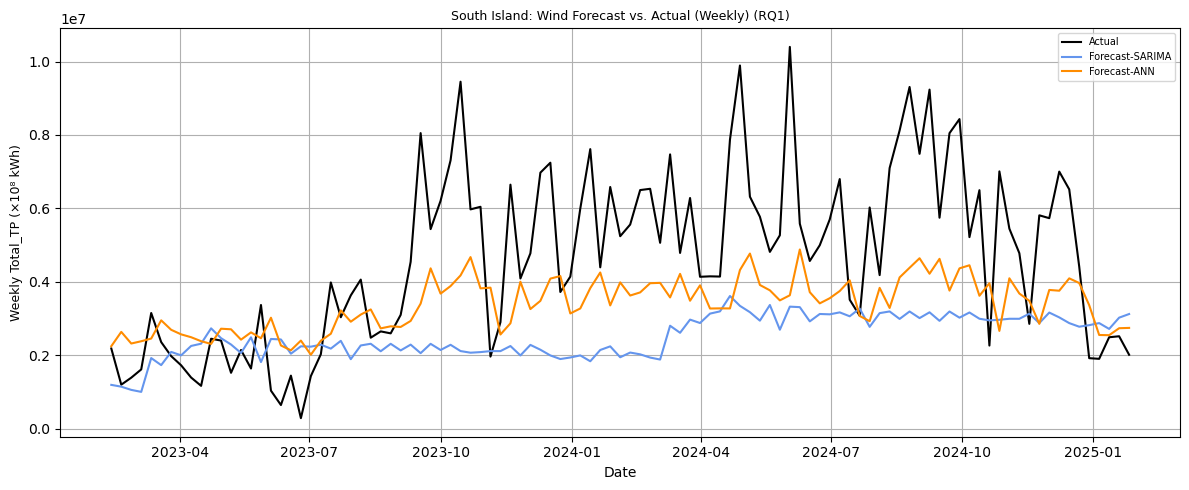

In [258]:
# # Plot Actual vs. Forecast
# plt.figure(figsize=(14, 7))
# plt.plot(train_weekly.index, target_train, label='Train', color='blue')
# plt.plot(test_weekly.index, target_test, label='Test', color='green')
# plt.plot(test_weekly.index, forecast, label='Forecast', color='red', linestyle='--')
# plt.xlabel("Date")
# plt.ylabel("Total_TP")
# plt.title("Daily SARIMAX Forecast-North Island (Without Log Transformation)")
# plt.legend()
# plt.tight_layout()
# plt.show()

# 1. Obtain the forecast object from the fitted results:
n_steps = len(target_test)
fc_n = results.get_forecast(steps=n_steps)  
# If you used exogenous variables when fitting, replace with:
# fc_n = results_n.get_forecast(steps=n_steps, exog=exog_test)

# 2. Extract the predicted mean and confidence intervals:
forecast = fc_n.predicted_mean
conf_int = fc_n.conf_int()

# 3. Plot train, actual, forecast, and CI:
plt.figure(figsize=(12, 5))

# plt.plot(train_weekly.index, target_train, label="Train", color="gray")
plt.plot(test_weekly.index,  target_test,  label="Actual", color="black")
plt.plot(forecast.index,       forecast,     label="Forecast-SARIMA", color="cornflowerblue")
plt.plot(test_s_ann.index, y_pred_south, label="Forecast-ANN",      color="darkorange")

# plt.fill_between(
#     conf_int.index,
#     conf_int.iloc[:, 0],  # lower bound
#     conf_int.iloc[:, 1],  # upper bound
#     color="lightblue",
#     alpha=0.2
# )

plt.legend()
plt.title("South Island: Wind Forecast vs. Actual (Weekly) (RQ1)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.legend(loc="upper right", fontsize=7)
plt.tight_layout()
plt.show()

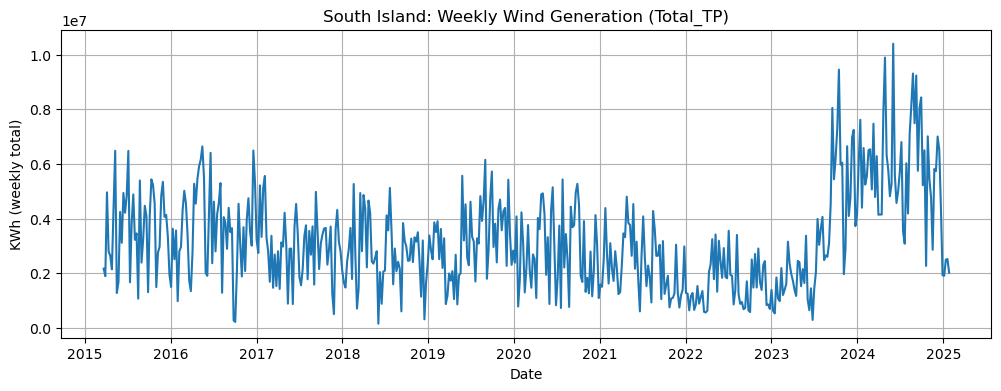

In [259]:
plt.figure(figsize=(12,4))
plt.plot(df_wind_weekly_lagged_south['Total_TP'], linestyle='-')
plt.title("South Island: Weekly Wind Generation (Total_TP)")
plt.ylabel("KWh (weekly total)")
plt.xlabel("Date")
plt.grid(True)
plt.show()

In [260]:
#exog_cols = ['WS50M']
#exog_cols = ['WS50M']
#exog_cols = ['WS50M']
# exog_cols = ['WS50M', 'TP_lag1w']
exog_cols = ['TP_lag1w']

In [262]:
exog_train = train_weekly[exog_cols]
exog_test = test_weekly[exog_cols]

In [264]:
# Fit SARIMAX on the original (log) target data
model_s = SARIMAX(target_train,
                exog=exog_train,
                order=(0, 1, 1),
                seasonal_order=(0, 1, 1, 52),
                enforce_stationarity=False,
                enforce_invertibility=False)
results_s = model_s.fit(disp=False)
print(results_s.summary())

                                     SARIMAX Results                                      
Dep. Variable:                           Total_TP   No. Observations:                  412
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 52)   Log Likelihood               -4753.125
Date:                            Thu, 05 Jun 2025   AIC                           9514.251
Time:                                    10:55:19   BIC                           9529.132
Sample:                                03-22-2015   HQIC                          9520.203
                                     - 02-05-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TP_lag1w       0.1619      0.188      0.860      0.390      -0.207       0.531
ma.L1         -0.8621      0.086   

In [268]:
# Forecast on the test set
n_steps_s = len(test_weekly)
forecast_s = results_s.get_forecast(steps=n_steps_s, exog=exog_test).predicted_mean

In [270]:
# Compute performance metrics
rmse = np.sqrt(mean_squared_error(target_test, forecast_s))
mae = mean_absolute_error(target_test, forecast_s)
epsilon = 1e-10  # small constant to avoid division by zero in MAPE
mape = np.mean(np.abs((target_test - forecast_s) / (target_test + epsilon))) * 100

# print("\nForecast Performance Metrics (With Log Transformation):")
# print(f"RMSE: {rmse:.2f}")
# print(f"MAE: {mae:.2f}")
# print(f"Adjusted MAPE: {mape:.2f}%")
print("South Island Wind SARIMA(0, 1, 1)x(0, 1, 0, 52) → MAE:", f"{mae:.2f}",
      "RMSE:", f"{rmse:.2f}", "MAPE:", f"{mape:.2f}%")

South Island Wind SARIMA(0, 1, 1)x(0, 1, 0, 52) → MAE: 2082259.71 RMSE: 2655870.47 MAPE: 48.10%


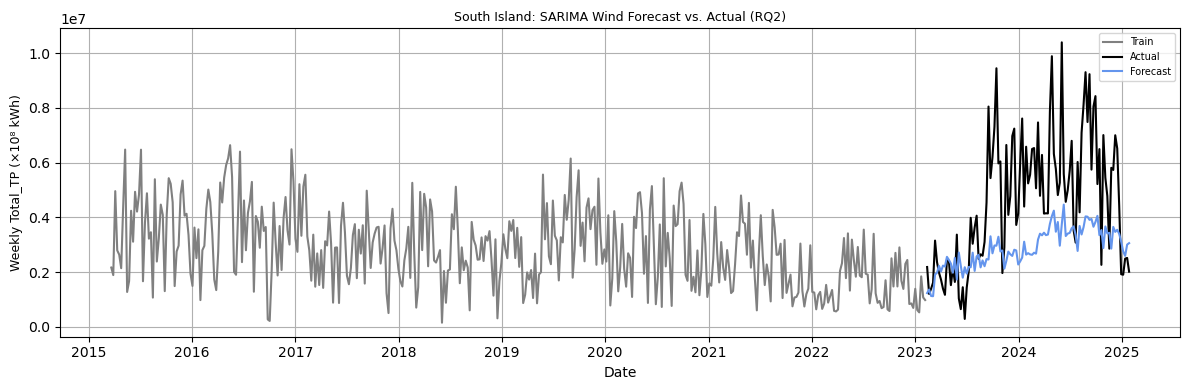

In [272]:
# Plot Actual vs. Forecast
# plt.figure(figsize=(16, 8))
# plt.plot(train_weekly.index, target_train_log, label='Train', color='blue')
# plt.plot(test_weekly.index, target_test_log, label='Test', color='green')
# plt.plot(test_weekly.index, forecast_log, label='Forecast', color='red', linestyle='--')
# plt.xlabel("Date")
# plt.ylabel("Total_TP")
# plt.title("Daily SARIMAX Forecast-North Island (With Log Transformation)")
# plt.legend()
# plt.tight_layout()
# plt.show()

n_steps_s = len(target_test)
#fc_n = results_s.get_forecast(steps=n_steps)  
# If you used exogenous variables when fitting, replace with:
fc_n = results_s.get_forecast(steps=n_steps_s, exog=exog_test)

# 2. Extract the predicted mean and confidence intervals:
forecast = fc_n.predicted_mean
conf_int = fc_n.conf_int()

# 3. Plot train, actual, forecast, and CI:
plt.figure(figsize=(12, 4))

plt.plot(train_weekly.index, target_train, label="Train", color="gray")
plt.plot(test_weekly.index,  target_test,  label="Actual", color="black")
plt.plot(forecast.index,       forecast,     label="Forecast", color="cornflowerblue")

# plt.fill_between(
#     conf_int.index,
#     conf_int.iloc[:, 0],  # lower bound
#     conf_int.iloc[:, 1],  # upper bound
#     color="lightblue",
#     alpha=0.2
# )

plt.legend()
plt.title("South Island: SARIMA Wind Forecast vs. Actual (RQ2)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.legend(loc="upper right", fontsize=7)
plt.tight_layout()
plt.show()

In [274]:
# -----------------------------------------------------------------------------
# ASSUMPTIONS / PREDEFINED for South Island ANN:
# -----------------------------------------------------------------------------
# • df_wind_weekly_lagged_south : pandas.DataFrame indexed by a weekly DateTimeIndex,
#      containing at least these columns:
#        – 'Total_TP'       (target series, e.g. weekly South‐Island wind output in kWh)
#        – 'WS50M'          (wind speed at 50 m)
#        – 'TP_lag1w'       (Total_TP lagged by one week)
#        – 'WS50M_EWMA'     (EWMA of WS50M)
# -----------------------------------------------------------------------------

# 1) Define the three candidate factors for South Island:
factors_south = ['WS50M', 'TP_lag1w', 'WS50M_EWMA']

# 2) Train/test split (80/20) on South Island data
n_south = len(df_wind_weekly_lagged_south)
split_idx_s = int(n_south * 0.8)

train_df_south = df_wind_weekly_lagged_south.iloc[:split_idx_s].copy()
test_df_south  = df_wind_weekly_lagged_south.iloc[split_idx_s:].copy()

# 3) Extract raw X and y for train/test
X_train_raw_south = train_df_south[factors_south].values
X_test_raw_south  = test_df_south[factors_south].values
y_train_raw_south = train_df_south['Total_TP'].values.reshape(-1, 1)
y_test_raw_south  = test_df_south['Total_TP'].values.reshape(-1, 1)

# 4) Scale X and y
x_scaler_south = StandardScaler().fit(X_train_raw_south)
y_scaler_south = StandardScaler().fit(y_train_raw_south)

X_train_south = x_scaler_south.transform(X_train_raw_south)
X_test_south  = x_scaler_south.transform(X_test_raw_south)
y_train_south = y_scaler_south.transform(y_train_raw_south)
y_test_south  = y_scaler_south.transform(y_test_raw_south)

# 5) Sanity‐check shapes
print("X_train_south:", X_train_south.shape, "y_train_south:", y_train_south.shape)
print("X_test_south: ", X_test_south.shape,  "y_test_south: ", y_test_south.shape)

# 6) Build the ANN (with an explicit Input layer)
def build_ann_south(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128),
        BatchNormalization(),
        LeakyReLU(negative_slope=0.1),
        Dropout(0.2),

        Dense(64),
        BatchNormalization(),
        LeakyReLU(negative_slope=0.1),
        Dropout(0.2),

        Dense(32),
        BatchNormalization(),
        LeakyReLU(negative_slope=0.1),

        Dense(1)  # linear output for regression
    ])
    return model

# 7) Instantiate and compile the South Island model
opt_south = tf.keras.optimizers.Adam(learning_rate=5e-4, clipnorm=1.0)
model_south = build_ann_south(X_train_south.shape[1])
model_south.compile(
    optimizer=opt_south,
    loss=Huber(delta=0.5),
    metrics=[tf.keras.metrics.MeanAbsolutePercentageError(name='mape')]
)

callbacks_south = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]

# 8) Train (use 10% of train_df_south as internal validation, keep test_df_south fully unseen)
history_south = model_south.fit(
    X_train_south, y_train_south,
    validation_split=0.10,
    epochs=200,
    batch_size=32,
    callbacks=callbacks_south,
    verbose=1
)

# 9) Predict & inverse‐scale for South Island
y_pred_scaled_south = model_south.predict(X_test_south)
y_pred_south_x = y_scaler_south.inverse_transform(y_pred_scaled_south).ravel()
y_true_south = y_scaler_south.inverse_transform(y_test_south).ravel()

# 10) Compute metrics for South Island
mae_south  = mean_absolute_error(y_true_south, y_pred_south_x)
rmse_south = np.sqrt(mean_squared_error(y_true_south, y_pred_south_x))
mape_south = mean_absolute_percentage_error(y_true_south, y_pred_south_x) * 100

print(f"RQ2: South Island (with regressors) - Wind - ANN - "
      f"MAE: {mae_south:.2f}, RMSE: {rmse_south:.2f}, MAPE: {mape_south:.2f}%")


X_train_south: (412, 3) y_train_south: (412, 1)
X_test_south:  (103, 3) y_test_south:  (103, 1)
Epoch 1/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2865 - mape: 1981.5269 - val_loss: 0.2659 - val_mape: 91.2895 - learning_rate: 5.0000e-04
Epoch 2/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2424 - mape: 6925.8662 - val_loss: 0.2609 - val_mape: 91.3842 - learning_rate: 5.0000e-04
Epoch 3/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2480 - mape: 3339.7114 - val_loss: 0.2623 - val_mape: 93.7995 - learning_rate: 5.0000e-04
Epoch 4/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2514 - mape: 6394.7437 - val_loss: 0.2589 - val_mape: 96.9013 - learning_rate: 5.0000e-04
Epoch 5/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2181 - mape: 4224.8506 - val_loss: 0.2552 - val_mape: 98.8327 - learning_rate: 5.0000e-04
Epoch 6/200
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2091 - mape: 2862.6326 - val_loss: 0.2544 - val_mape: 102.4980 - learning_rate: 5.0000

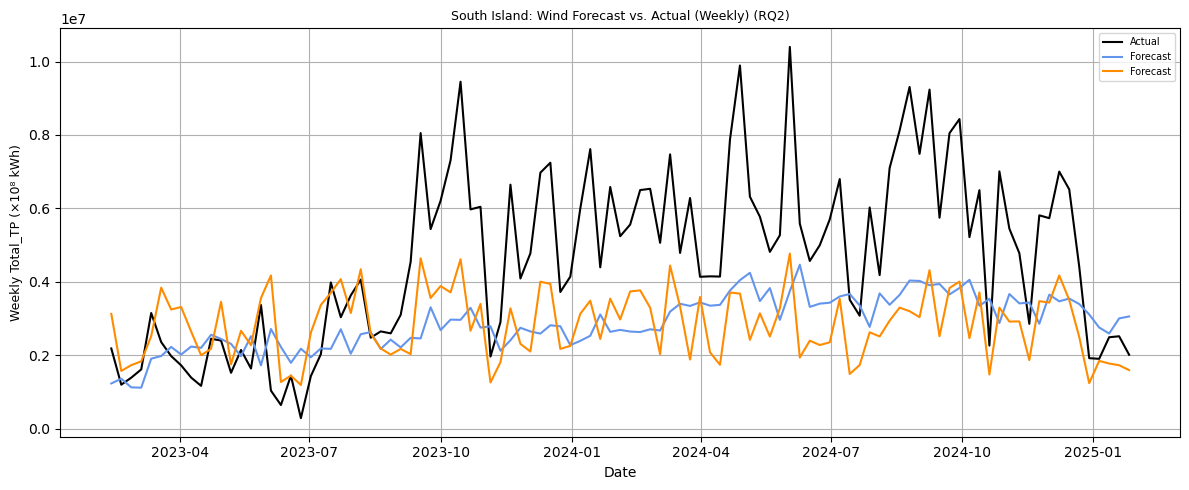

In [278]:
# Plot Actual vs. Forecast
# plt.figure(figsize=(16, 8))
# plt.plot(train_weekly.index, target_train_log, label='Train', color='blue')
# plt.plot(test_weekly.index, target_test_log, label='Test', color='green')
# plt.plot(test_weekly.index, forecast_log, label='Forecast', color='red', linestyle='--')
# plt.xlabel("Date")
# plt.ylabel("Total_TP")
# plt.title("Daily SARIMAX Forecast-North Island (With Log Transformation)")
# plt.legend()
# plt.tight_layout()
# plt.show()

n_steps_s = len(target_test)
#fc_n = results_s.get_forecast(steps=n_steps)  
# If you used exogenous variables when fitting, replace with:
fc_n = results_s.get_forecast(steps=n_steps_s, exog=exog_test)

# 2. Extract the predicted mean and confidence intervals:
forecast = fc_n.predicted_mean
conf_int = fc_n.conf_int()

# 3. Plot train, actual, forecast, and CI:
plt.figure(figsize=(12, 5))

#plt.plot(train_weekly.index, target_train, label="Train", color="gray")
plt.plot(test_weekly.index,  target_test,  label="Actual", color="black")
plt.plot(forecast.index,       forecast,     label="Forecast", color="cornflowerblue")
plt.plot(test_df_south.index,y_pred_south_x,label="Forecast", color="darkorange")
# plt.fill_between(
#     conf_int.index,
#     conf_int.iloc[:, 0],  # lower bound
#     conf_int.iloc[:, 1],  # upper bound
#     color="lightblue",
#     alpha=0.2
# )

plt.legend()
plt.title("South Island: Wind Forecast vs. Actual (Weekly) (RQ2)" , fontsize=9)
plt.xlabel("Date")
plt.ylabel("Weekly Total_TP (×10⁸ kWh)" ,  fontsize=9)
plt.grid(True)
plt.legend(loc="upper right", fontsize=7)
plt.tight_layout()
plt.show()

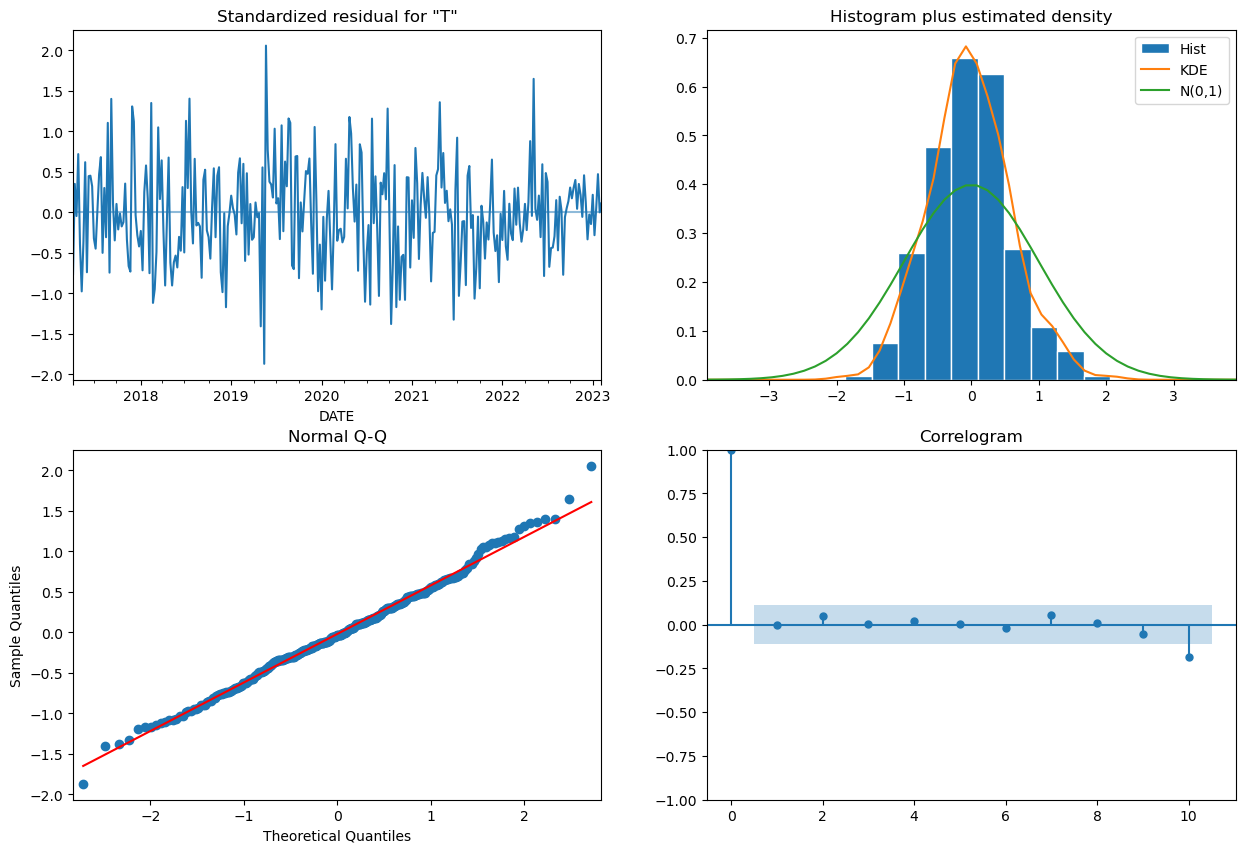

In [402]:
results_s.plot_diagnostics(figsize=(15, 10))
plt.show()

In [390]:
import pmdarima as pm

auto_mod = pm.auto_arima(
    target_train,
    exogenous=exog_train,          # or omit for pure SARIMA
    seasonal=True,
    m=52,
    d=1,
    D=1,
    max_p=2, max_q=2, max_P=1, max_Q=1,
    information_criterion='aic',
    stepwise=True,
    trace=True
)
print(auto_mod.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[52]             : AIC=inf, Time=17.31 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=11488.779, Time=0.43 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=11348.227, Time=2.36 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=3.44 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=11430.247, Time=0.45 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=4.82 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=3.51 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=11391.082, Time=1.79 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=11315.164, Time=3.18 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=11401.064, Time=0.65 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=6.48 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=5.76 sec
 ARIMA(2,1,1)(1,1,0)[52]             : AIC=11275.390, Time=6.30 sec
 ARIMA(2,1,1)(0,1,0)[52]             : AIC=11352.648, Time=1.15 sec
 ARIMA(2,1,1)(1,1,1)[52]             : A

If a zero actually means no generation (e.g., turbine was off), you might not want to interpolate—but if it’s a data artifact or gap, this is valid.